# German Credit Card Classification

For financial institutions, credit risk assessment is a crucial task that enables them to distinguish between "good" and "bad" customers—in other words, to determine whether an applicant is eligible for credit. The development of machine learning techniques in recent years has significantly improved this selection process.

The aim of this project is twofold. Firstly, it involves describing and performing exploratory data analysis on the 'German Credit Data' dataset to maximize insight into the dataset and its structure. Secondly, using the knowledge gained from this analysis, different data mining techniques will be employed to classify bank customers as 'good' or 'bad.' These classification models will be compared to select the best one, with the goal of increasing the efficiency of predicting whether a given customer is suitable for credit. Additionaly different feature subsets will be used to increase classification performance.

In [460]:
import warnings
warnings.filterwarnings('ignore')
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import ADASYN, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import plot_roc_curve, auc
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

import dtreeviz.trees
from sklearn import tree

pd.set_option('display.max_colwidth', None)

## Loading the data

I will load the data using ucimlrepo package in Python, as it is suggested here https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data. I will use the 'original' data, not the numeric version.

In [461]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

# transforming data into dataframe
df = statlog_german_credit_data['data']['original'] 
df.head(3)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


## Data Cleaning 



### 1. **Data Translation**

Since in this way the data is less readable, we will redefine column names and variables according to the description from the documentation. 



In [462]:
names = ['Existing Checking', 'Duration', 'Credit History', 'Purpose', 'Credit Amount', 
         'Savings', 'Employment Since', 'Installment Rate', 'Status Sex', 'Other Debtors', 
         'Residence Since', 'Property', 'Age', 'Other Installment Plans', 'Housing', 
         'Existing Credits', 'Job', 'People Liable', 'Telephone', 'Foreign Worker', 'Classification']
df.columns = names
df.head(3)

,Existing Checking,Duration,Credit History,Purpose,Credit Amount,Savings,Employment Since,Installment Rate,Status Sex,Other Debtors,...,Property,Age,Other Installment Plans,Housing,Existing Credits,Job,People Liable,Telephone,Foreign Worker,Classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


For the purpose of data description I will make a copy of the dataframe and translate the variables into more readable ones.

In [463]:
df_copy = df.copy()

Existing_Checking = {'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df_copy.replace({"Existing Checking": Existing_Checking}, inplace=True)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df_copy.replace({"Credit History" : Credit_history}, inplace=True)  

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df_copy.replace({ "Purpose": Purpose}, inplace=True)  

Savings={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df_copy.replace({ "Savings": Savings}, inplace=True) 

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df_copy.replace({ "Employment Since": Present_employment}, inplace=True)  

Status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
df_copy.replace({ "Status Sex": Status_and_sex}, inplace=True)   

Other_debtors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df_copy.replace({ "Other Debtors": Other_debtors}, inplace=True) 

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df_copy.replace({ "Property": Property}, inplace=True) 

Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df_copy.replace({ "Other Installment Plans": Other_installment_plans}, inplace=True)  

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df_copy.replace({ "Housing": Housing}, inplace=True) 

Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
df_copy.replace({ "Job": Job}, inplace=True) 

Telephone={'A192':"yes", 'A191':"none"}
df_copy.replace({ "Telephone": Telephone}, inplace=True) 

foreign_worker={'A201':"yes", 'A202':"no"}
df_copy.replace({ "Foreign Worker": foreign_worker}, inplace=True)  

Residence_since = {4:">=7 years", 3:"4<= <7 years",  2:"1<= < 4 years", 1:"<1 years"}
df_copy.replace({ "Residence Since": Residence_since}, inplace=True)

Installment_rate =  {4:"<20", 3:"20<= ... <25",  2:"25<=...< 35", 1:"=>35"}
df_copy.replace({ "Installment Rate": Installment_rate}, inplace=True)

Existing_Credits = {1: "1", 2: "2 or 3", 3: "4 or 5", 4: "6 or more"}
df_copy.replace({ "Existing Credits": Existing_Credits}, inplace=True)

People_Liable = {1: "3 or more", 2: "0 to 2"}
df_copy.replace({ "People Liable": People_Liable}, inplace=True)

df_copy.replace({"Classification" : {1: "Good", 2: "Bad"}}, inplace=True)

df_copy.head(2)

,Existing Checking,Duration,Credit History,Purpose,Credit Amount,Savings,Employment Since,Installment Rate,Status Sex,Other Debtors,...,Property,Age,Other Installment Plans,Housing,Existing Credits,Job,People Liable,Telephone,Foreign Worker,Classification
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,<20,male:single,none,...,real estate,67,none,own,2 or 3,skilled employee / official,3 or more,yes,yes,Good
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,25<=...< 35,female:divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,3 or more,none,yes,Bad


### 2. **Data Inspection:**
   - **Dataset Size** 
   - **Missing Values** 
   - **Duplicates** 
   - **Data Types** 

In [464]:
df.shape

(1000, 21)

Here we can see that the dataset contains 21 attributes (20 features and 1 traget variables) and consists of 1000 records.

In [465]:
df.isna().sum()

Existing Checking          0
Duration                   0
Credit History             0
Purpose                    0
Credit Amount              0
Savings                    0
Employment Since           0
Installment Rate           0
Status Sex                 0
Other Debtors              0
Residence Since            0
Property                   0
Age                        0
Other Installment Plans    0
Housing                    0
Existing Credits           0
Job                        0
People Liable              0
Telephone                  0
Foreign Worker             0
Classification             0
dtype: int64

We can also check for duplicated values. There are none.

In [466]:
df.duplicated().sum()

0

Here we have verified that our set does not contain any missing values. Let's now look at the data types.

In [467]:
d_types_table = pd.DataFrame(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Existing Checking        1000 non-null   object
 1   Duration                 1000 non-null   int64 
 2   Credit History           1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   Credit Amount            1000 non-null   int64 
 5   Savings                  1000 non-null   object
 6   Employment Since         1000 non-null   object
 7   Installment Rate         1000 non-null   int64 
 8   Status Sex               1000 non-null   object
 9   Other Debtors            1000 non-null   object
 10  Residence Since          1000 non-null   int64 
 11  Property                 1000 non-null   object
 12  Age                      1000 non-null   int64 
 13  Other Installment Plans  1000 non-null   object
 14  Housing                  1000 non-null   

Here we can see that the only datatypes used in this dataset are object (for categorical variables)  and int64 for numerical variables. We can switch the object datatype to dtype='category'.

In [468]:
datatypes = df.columns.to_series().groupby(df.dtypes).groups
datatypes_dict = {k.name: v for k, v in datatypes.items()}

In [469]:
for column in list(datatypes_dict['object']):
    df[column] = df[column].astype("category")

df['Classification'] = df['Classification'].astype("category")

In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Existing Checking        1000 non-null   category
 1   Duration                 1000 non-null   int64   
 2   Credit History           1000 non-null   category
 3   Purpose                  1000 non-null   category
 4   Credit Amount            1000 non-null   int64   
 5   Savings                  1000 non-null   category
 6   Employment Since         1000 non-null   category
 7   Installment Rate         1000 non-null   int64   
 8   Status Sex               1000 non-null   category
 9   Other Debtors            1000 non-null   category
 10  Residence Since          1000 non-null   int64   
 11  Property                 1000 non-null   category
 12  Age                      1000 non-null   int64   
 13  Other Installment Plans  1000 non-null   category
 14  Housing  

Here we can also check for number of unique values for each feature and check with data description if they are correct.

In [471]:
df.nunique()

Existing Checking            4
Duration                    33
Credit History               5
Purpose                     10
Credit Amount              921
Savings                      5
Employment Since             5
Installment Rate             4
Status Sex                   4
Other Debtors                3
Residence Since              4
Property                     4
Age                         53
Other Installment Plans      3
Housing                      3
Existing Credits             4
Job                          4
People Liable                2
Telephone                    2
Foreign Worker               2
Classification               2
dtype: int64

In [472]:
for i, col in enumerate(df.select_dtypes(include =['category']).columns):
  print(i+1,col, "  : ",df[col].unique())

1 Existing Checking   :  ['A11', 'A12', 'A14', 'A13']
Categories (4, object): ['A11', 'A12', 'A13', 'A14']
2 Credit History   :  ['A34', 'A32', 'A33', 'A30', 'A31']
Categories (5, object): ['A30', 'A31', 'A32', 'A33', 'A34']
3 Purpose   :  ['A43', 'A46', 'A42', 'A40', 'A41', 'A49', 'A44', 'A45', 'A410', 'A48']
Categories (10, object): ['A40', 'A41', 'A410', 'A42', ..., 'A45', 'A46', 'A48', 'A49']
4 Savings   :  ['A65', 'A61', 'A63', 'A64', 'A62']
Categories (5, object): ['A61', 'A62', 'A63', 'A64', 'A65']
5 Employment Since   :  ['A75', 'A73', 'A74', 'A71', 'A72']
Categories (5, object): ['A71', 'A72', 'A73', 'A74', 'A75']
6 Status Sex   :  ['A93', 'A92', 'A91', 'A94']
Categories (4, object): ['A91', 'A92', 'A93', 'A94']
7 Other Debtors   :  ['A101', 'A103', 'A102']
Categories (3, object): ['A101', 'A102', 'A103']
8 Property   :  ['A121', 'A122', 'A124', 'A123']
Categories (4, object): ['A121', 'A122', 'A123', 'A124']
9 Other Installment Plans   :  ['A143', 'A141', 'A142']
Categories (

Looking at the output above for categorical data, we can observe that the value 'A95' does not appear in the dataset (which means single female), as well as 'A47' which means vacation.


### 3. **Categorical Feature Review and Consolidation**


Since there are very many categories for some of the features, I have decided to first look at the distribution of each category of a feature and then group some of the rare ones, which come from similar groups.

In [473]:
numerical_col = ['Age', 'Duration', 'Credit Amount']

column_names = df_copy.columns.tolist()
for col in numerical_col:
    column_names.remove(col)

column_names_cat={}
for name in column_names:
    column_names_cat[name]=df_copy[name].nunique()


# Clustering the attributes by number on unique values
marginal_report_cluster={}
for itr in range(0,np.asarray(list(column_names_cat.values())).max()+1):
    if [k for k,v in column_names_cat.items() if v == itr]:
        marginal_report_cluster[itr]=[k for k,v in column_names_cat.items() if v == itr]

# Report lists with percentages for each variable
report_list = []
for key in marginal_report_cluster.keys():
    marginal_percentage_report=[]
    for name in sorted(marginal_report_cluster[key]):
        data=pd.crosstab(df_copy[name],columns=["Percentage"]).apply(lambda r: (round((r/r.sum())*100,2)), axis=0).reset_index()
        data.columns=[name,"Percentage"]
        data=data.transpose().reset_index()
        [marginal_percentage_report.append(x) for x in data.values.tolist()]
        options=[]
    marginal_percentage_report=pd.DataFrame(marginal_percentage_report)
    [options.append("Category "+str(itr)) for itr in range(1,len(marginal_percentage_report.columns))]
    marginal_percentage_report.columns=["Attribute"]+options
    report_list.append(marginal_percentage_report)

In [474]:
report_list[0]

,Attribute,Category 1,Category 2
0,Classification,Bad,Good
1,Percentage,30.0,70.0
2,Foreign Worker,no,yes
3,Percentage,3.7,96.3
4,People Liable,0 to 2,3 or more
5,Percentage,15.5,84.5
6,Telephone,none,yes
7,Percentage,59.6,40.4





• **Classification**: The first and most important observation is that there is slight **class imbalance**, since there are 70% credit recipients which were classified as Good (1) and 30% credit recipients which were classified as Bad (2). I will tackle this issue in the preprocessing step.

• **Foreign Worker**: Here there is a much larger imbalance since Foreign Workers are only 3.7%.

• **People Liable**: Similarly here there is an imbalance, most People Liable are in the 1 category (84.5%).

• **Telephone**: This is one of the most even features in terms of category distribution.

In [475]:
report_list[1]

,Attribute,Category 1,Category 2,Category 3
0,Housing,for free,own,rent
1,Percentage,10.8,71.3,17.9
2,Other Debtors,co-applicant,guarantor,none
3,Percentage,4.1,5.2,90.7
4,Other Installment Plans,bank,none,store
5,Percentage,13.9,81.4,4.7




• **Housing**: Around 70% of people own their home. Minorities either rent (17.9%) or have the house ’for free’ 10.8%.

• **Other Debtors**: Large majority does not have other debtors (90%).

• **Other Installment Plans**: Most people do not have other installment plans 81.4%, some have bank or store.

In [476]:
report_list[2]

,Attribute,Category 1,Category 2,Category 3,Category 4
0,Existing Checking,0 <= <200 DM,<0 DM,>= 200 DM,no checking account
1,Percentage,26.9,27.4,6.3,39.4
2,Existing Credits,1,2 or 3,4 or 5,6 or more
3,Percentage,63.3,33.3,2.8,0.6
4,Installment Rate,20<= ... <25,25<=...< 35,<20,=>35
5,Percentage,15.7,23.1,47.6,13.6
6,Job,management/ highly qualified employee,skilled employee / official,unemployed/ unskilled - non-resident,unskilled - resident
7,Percentage,14.8,63.0,2.2,20.0
8,Property,car or other,real estate,savings agreement/life insurance,unknown / no property
9,Percentage,33.2,28.2,23.2,15.4




• **Existing Checking**: Most applicants have no checking account (39%). Very few have more than 200 DM in a checking account (6.3%).

• **Existing Credits**: Large majority of credit recipients are in the 1 or 2 category (63.3%, 33.3%), according to the article mentioned before it could be treated as 1 and 2 or 3 existing credits respectively. 

• **Installment Rate**: Most people have their installment rates in group 4, which according to the article 1, means that they have their installment rate below 20% of their disposable income.

• **Job**: Here very few applicants are considered as unemployed/ unskilled - non-resident (2.2%). The group for unskilled - resident is 20%, most people are considered skilled employee 63%.

• **Property**: This attribute refers to ones most valuable property. For 33.3% car or other is the most valuable property, close second is real estate 28.2%. This is one of the most balanced features.

• **Residence Since**: This feature describes how long someone has been a present resident. Most people were categorized as 4 (over 40%), which according to 1, means that they have been present residence for more than 7 years.

• **Status Sex**: This category and its distribution is quite confusing. We can clearly see that most recipients were single men, There are separate categories for male: divorced/ separated and male: married / widowed. Since there are very few of those in the next step I have decides to combine these categories and have just men and women.



In [477]:
report_list[3]

,Attribute,Category 1,Category 2,Category 3,Category 4,Category 5
0,Credit History,all credits at this bank paid back duly,critical account,delay in paying off,existing credits paid back duly till now,no credits taken
1,Percentage,4.9,29.3,8.8,53.0,4.0
2,Employment Since,1<= < 4 years,4<= <7 years,<1 years,>=7 years,unemployed
3,Percentage,33.9,17.4,17.2,25.3,6.2
4,Savings,100 <= <500 DM,500 <= < 1000 DM,<100 DM,>= 1000 DM,no savings account
5,Percentage,10.3,6.3,60.3,4.8,18.3



• **Credit History**: More than half of the recipients have their existing credits paid back duly till now (53%).

• **Employment Since**: This is one of the most balanced features. Most people have been employed at their current position for either 1 to 4 years (33.9%) or more than 7 years (25.3%)

• **Savings**: Majority of applicants have savings below 100 DM (60.3%). Quite a lot of them
do not have savings at all (18.3%)

In [478]:
report_list[4]

,Attribute,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,Purpose,business,car (new),car (used),domestic appliances,education,furniture/equipment,others,radio/television,repairs,retraining
1,Percentage,9.7,23.4,10.3,1.2,5.0,18.1,1.2,28.0,2.2,0.9




• **Purpose**: Here radio/television is the majority group 28%, then second is new cars, then furniture/equipment. People rarely were taking credits for repairs, education or retraining.

---

Before continuing with visualization I have decided to combine some categories which were rare and similar in meaning. I have performed the following transformation:

• **Status Sex** : Here I have combined them in a way to obtain categories for male and female.

• **Job** : Since the unemployed/ unskilled - non-resident group was very small I have merged it with unskilled - resident as unskilled / unemployed group.

• **Existing Credit** : Here I have combined categories 3 and 4 from now on they will stand for ”4 or more” existing credits.

In [479]:
df_copy2 = df.copy()

Existing_Checking = {'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df_copy2.replace({"Existing Checking": Existing_Checking}, inplace=True)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df_copy2.replace({"Credit History" : Credit_history}, inplace=True)  

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df_copy2.replace({ "Purpose": Purpose}, inplace=True)  

Savings={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df_copy2.replace({ "Savings": Savings}, inplace=True) 

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df_copy2.replace({ "Employment Since": Present_employment}, inplace=True)  

# Combined to sex feature
Status_and_sex={ 'A95':"female",'A94':"male",'A93':"male", 'A92':"female", 'A91':"male"}
df_copy2.replace({ "Status Sex": Status_and_sex}, inplace=True)   

Other_debtors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df_copy2.replace({ "Other Debtors": Other_debtors}, inplace=True) 

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df_copy2.replace({ "Property": Property}, inplace=True) 

Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df_copy2.replace({ "Other Installment Plans": Other_installment_plans}, inplace=True)  

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df_copy2.replace({ "Housing": Housing}, inplace=True) 

# Combining categories for Job 
Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unemployed/ unskilled", 'A171':"unemployed/ unskilled"} 
df_copy2.replace({ "Job": Job}, inplace=True) 

Telephone={'A192':"yes", 'A191':"none"}
df_copy2.replace({ "Telephone": Telephone}, inplace=True) 

foreign_worker={'A201':"yes", 'A202':"no"}
df_copy2.replace({ "Foreign Worker": foreign_worker}, inplace=True)  

Residence_since = {4:">=7 years", 3:"4<= <7 years",  2:"1<= < 4 years", 1:"<1 years"}
df_copy2.replace({ "Residence Since": Residence_since}, inplace=True)

Installment_rate =  {4:"<20", 3:"20<= ... <25",  2:"25<=...< 35", 1:"=>35"}
df_copy2.replace({ "Installment Rate": Installment_rate}, inplace=True)

# Combined to 4 or more
Existing_Credits = {1: "1", 2: "2 or 3", 3: "4 or more", 4: "4 or more"}
df_copy2.replace({ "Existing Credits": Existing_Credits}, inplace=True)

People_Liable = {1: "3 or more", 2: "0 to 2"}
df_copy2.replace({ "People Liable": People_Liable}, inplace=True)

df_copy2.replace({"Classification" : {1: "Good", 2: "Bad"}}, inplace=True)

df_copy2.head(2)

,Existing Checking,Duration,Credit History,Purpose,Credit Amount,Savings,Employment Since,Installment Rate,Status Sex,Other Debtors,...,Property,Age,Other Installment Plans,Housing,Existing Credits,Job,People Liable,Telephone,Foreign Worker,Classification
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,<20,male,none,...,real estate,67,none,own,2 or 3,skilled employee / official,3 or more,yes,yes,Good
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,25<=...< 35,female,none,...,real estate,22,none,own,1,skilled employee / official,3 or more,none,yes,Bad


In [480]:
# Merging for original df
df_comb = df.copy()

# Combined to sex feature
Sex={ 'A95':'A92','A94':'A91','A93':'A91', 'A92':'A92', 'A91':'A91'}
df_comb.replace({ "Status Sex": Sex}, inplace=True) 

# Combining categories for Job 
Job={'A174':'A174', 'A173':'A173', 'A172':'A172', 'A171':'A172'} 
df_comb.replace({ "Job": Job}, inplace=True) 

# Combined to 4 or more
Existing_Credits = {1: 1, 2: 2, 3: 3, 4: 3}
df_comb.replace({ "Existing Credits": Existing_Credits}, inplace=True)


## Exploratory Data Analysis (EDA)

The primary objective of this EDA was to prepare the dataset for classification algorithms by identifying key features that are crucial for classification. This analysis helped in pinpointing the most significant features and relationships, providing valuable insights for improving classification performance.

## Univariate Analysis

### 1. Continuous Variables

Let us first look at some basic statistics.

In [481]:
df[numerical_col].describe()

,Age,Duration,Credit Amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


Looking at the table above, we see that the mean age of a loaner is about 35, while the youngest one is 19 and oldest is 75. These statistics also show that we do not have any anomalies in the data (like people age -20). The 3rd quartile is 42, which suggest that mostly young people, below age 42 take credits. 

Statistics for duration show that the mean duration is approximately 21 months and the standard deviation is 12 months. This makes sense since most bank give credits for durations that round up to years (1, 2 or 3 years) and rarely for example for 14 months. Looking at the table we can also notice that the minimun duration is 4 months (quarter), and maximum is 72 months which is equal to 6 years. 

The column with credit amount shows that the lowest credit was taken for 250 DM and the highest one for 18424 DM. The standard deviation is quite large for this column, which we may assume comes from the fact that the credits were taken for different purposes (some very expensive ones and some affordable ones). The mean credit amount is 3271 DM. 

In [482]:
def histogram_boxplot(data, feature):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  
        sharex=True, 
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=(12, 7))  
    
    sns.boxplot(data=data, x=feature, ax=ax_box2)
    sns.histplot(data=data, x=feature, kde=None, ax=ax_hist2, bins = 12) 


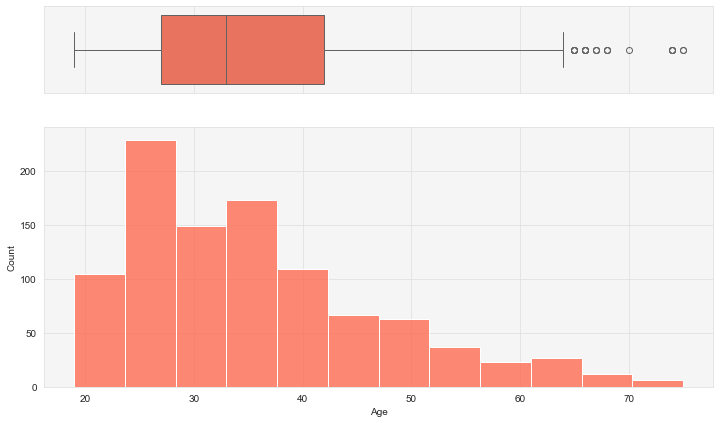

In [483]:
histogram_boxplot(df, "Age")

Here we can see that the histogram is right / positive skewd. The most applicants for credit are between age 20 and 30. Looking at the histogram we can see some outliers (according to the definition based on boxplot interpretation), we can say that very few people decide to take a loan around the age of 70. 

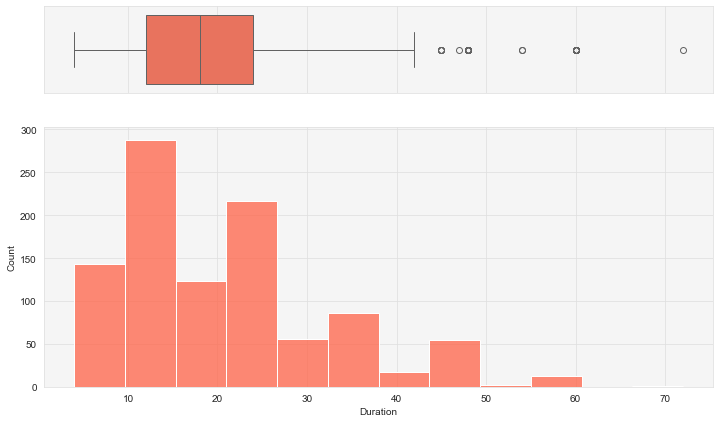

In [484]:
histogram_boxplot(df, "Duration")

Here the histogram for the duration in months is more sparsely spread. We can assume that most common duration is 12 or 24 months, while the credits taken for duration longer than 4 years (48 months) are rare.

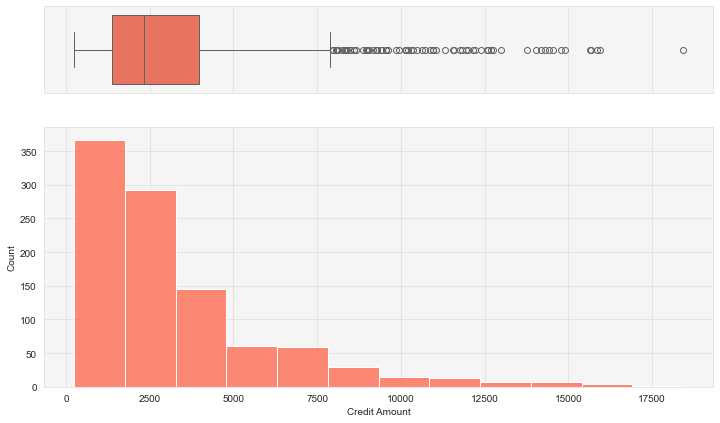

In [485]:
histogram_boxplot(df, "Credit Amount")

The histogram for Credit Amount is definitly right skewed, which means that most people take credits for low amounts. As mentioned in the section with basic statistics, we can see that the data for 'Credit Amount' has high variability.

### 2. Categorical Variables

To visualize categorical features I have prepared a set of barplots, which represent the frequency of
each category.

In [486]:
# Dividing the column names into chunks for plotting
chunks = [column_names[x:x+3] for x in [0,3,6,9,12,15]]

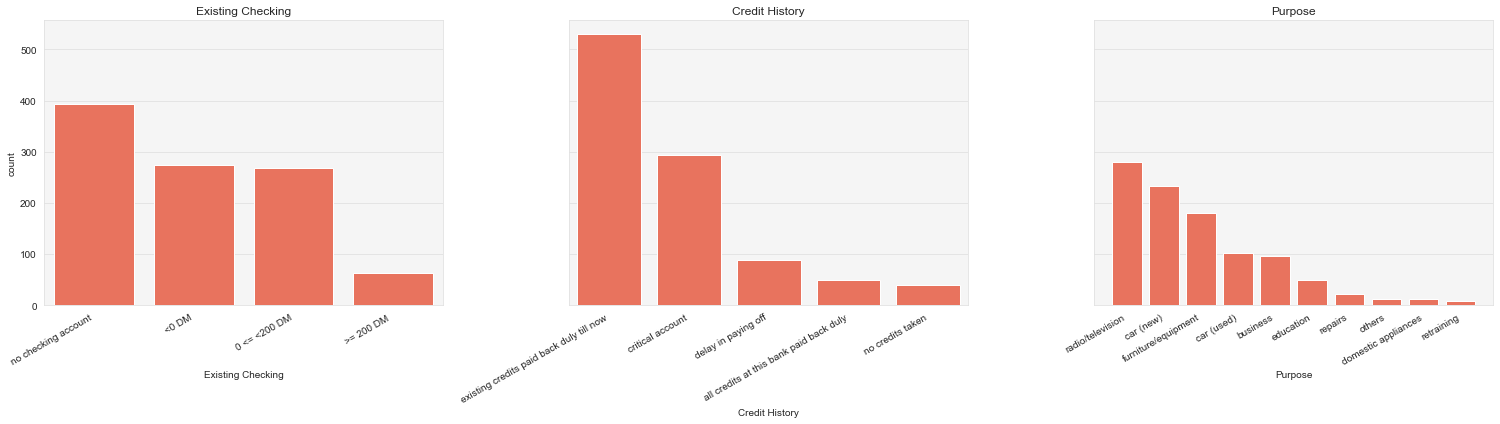

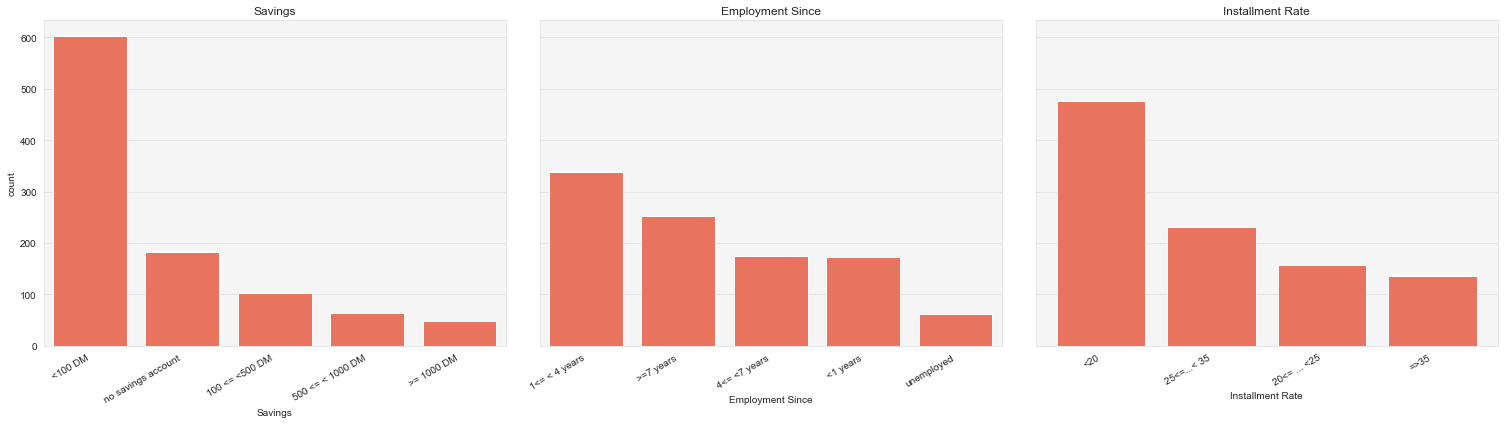

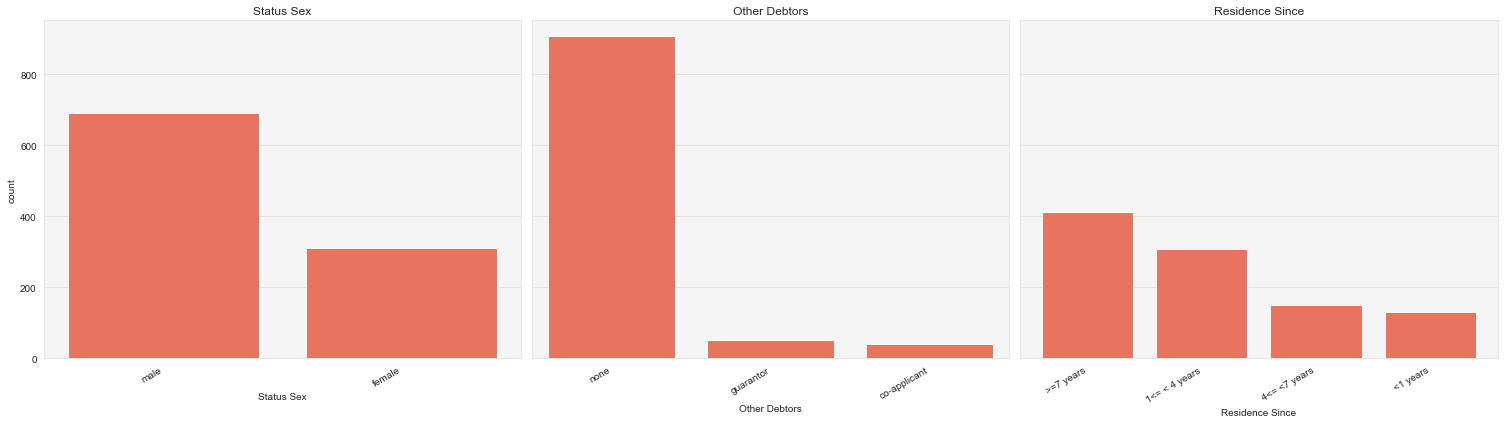

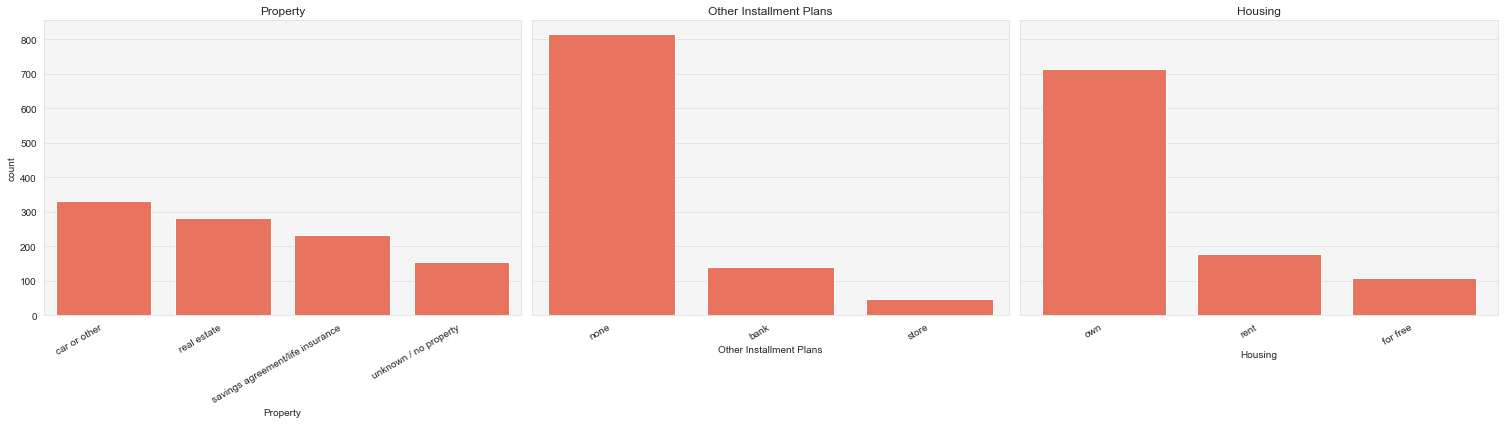

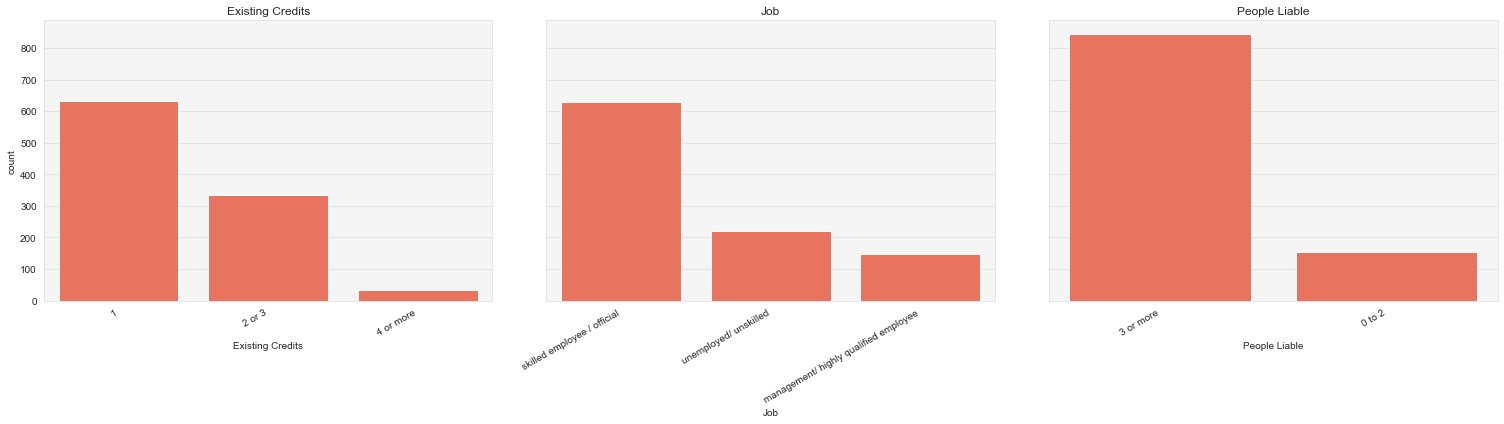

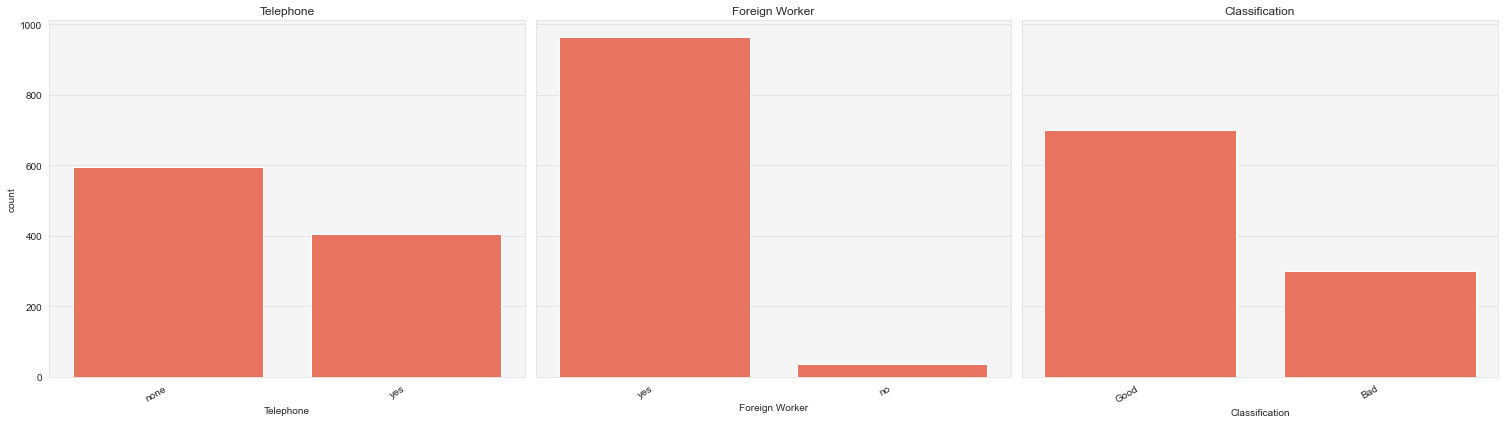

In [487]:
def plot_3_barplots(chunk, data):

    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

    sns.countplot(ax=axes[0], x=chunk[0] , data = data, order = data[chunk[0]].value_counts().index)
    axes[0].set_title(chunk[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[1], x=chunk[1] , data = data, order = data[chunk[1]].value_counts().index)
    axes[1].set_title(chunk[1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[2], x=chunk[2] , data = data, order = data[chunk[2]].value_counts().index)
    axes[2].set_title(chunk[2])
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, ha="right")

    
    plt.tight_layout()
    plt.plot()

for i in chunks:
    plot_3_barplots(i, df_copy2)

Conclusions for the barplots are very similar to conclusions from distribution tables from section 3. **Categorical Feature Review and Consolidation**. Therefore I will only discuss the features which have been altered.

• **Status Sex** : We can see that there is a disproportion between male and female applicants.
About 70% of them are male.


• **Job**: The smallest group is management / highly qualified employees. The largest group is
skilled employee / official. There is noticable disproportion for this feature.


• **Existing Credit** : Here after the transformation ”4 or more” group is still a visible minority.
Over half of applicants have just 1 existing credit.

## Bivariate Analysis

### 1. Numerical Data

In [488]:
good = df_copy2[df_copy2['Classification'] == 'Good']
bad = df_copy2[df_copy2['Classification'] == 'Bad']

In [489]:
summary_good_bad = pd.concat([bad.describe(),good.describe()], axis = 1)
summary_good_bad.columns = ["Duration_bad", "Credit Amount_bad", "Age_bad", "Duration_good", "Credit Amount_good", "Age_good"]
summary_good_bad = pd.concat([summary_good_bad["Duration_bad"], summary_good_bad["Duration_good"] , summary_good_bad["Credit Amount_bad"] , summary_good_bad["Credit Amount_good"] , summary_good_bad["Age_bad"] , summary_good_bad["Age_good"] ] , axis = 1)
summary_good_bad.round(2)

,Duration_bad,Duration_good,Credit Amount_bad,Credit Amount_good,Age_bad,Age_good
count,300.00,700.00,300.00,700.00,300.00,700.00
mean,24.86,19.21,3938.13,2985.46,33.96,36.22
std,13.28,11.08,3535.82,2401.47,11.22,11.38
min,6.00,4.00,433.00,250.00,19.00,19.00
25%,12.00,12.00,1352.50,1375.50,25.00,27.00
50%,24.00,18.00,2574.50,2244.00,31.00,34.00
75%,36.00,24.00,5141.50,3634.75,40.00,42.25
max,72.00,60.00,18424.00,15857.00,74.00,75.00


Here is the comparison for "Bad" and "Good" group for continuos variables. 

* **Duration**: The mean duration is lower for "Good" customers. All other statistics are lower as well, which suggests that in general "Good" customers take credits for shorter duration.

* **Credit Amount**: Here the mean and minimum are noticably lower for "Good" customers as well as standard deviation. However Q1 and Q2 are similar. This suggests that "Bad" customers do not take credit for very low amounts  and generally take credit for larger sums. 

* **Age**: In general "Bad" customers are a bit younger. Allthough the range of age for "good" and "bad" applicants is very similar. **It seems Age is not a very good predictor compared to duration and credit amount.**

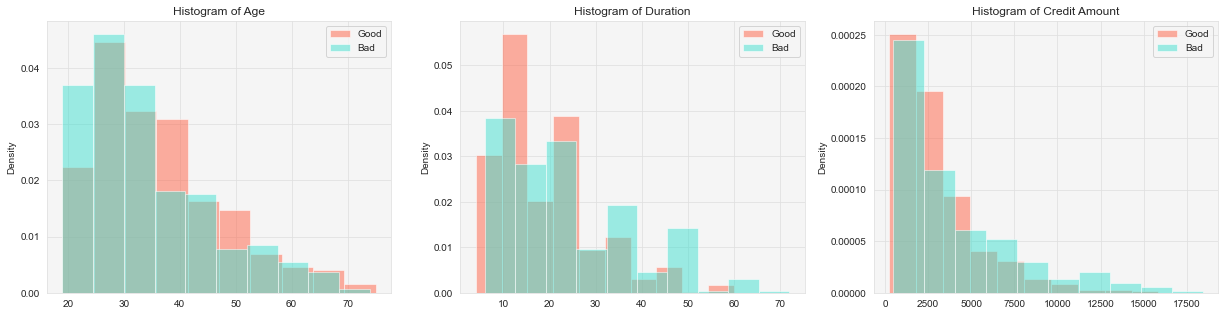

In [490]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

ax[0].hist(good["Age"], density = True, label = "Good", alpha=0.5)
ax[0].hist(bad["Age"], density = True, label = "Bad", alpha=0.5)
ax[0].legend()
ax[0].set_title("Histogram of Age")
ax[0].set_ylabel("Density")

ax[1].hist(good["Duration"], density = True, label = "Good", alpha=0.5)
ax[1].hist(bad["Duration"], density = True, label = "Bad", alpha=0.5)
ax[1].legend()
ax[1].set_title("Histogram of Duration")
ax[1].set_ylabel("Density")


ax[2].hist(good["Credit Amount"], density = True, label = "Good", alpha=0.5)
ax[2].hist(bad["Credit Amount"], density = True, label = "Bad", alpha=0.5)
ax[2].legend()
ax[2].set_title("Histogram of Credit Amount")
ax[2].set_ylabel("Density")

plt.show()

From the above set of histograms in general we can see similar shapes for both "Good" and "Bad" and also similar ranges.

* **Age** : Histogram for "Bad" group is more skewed compared to the other group. For "Good" group most people are between ages of 25 to 40, while for the "Bad" group most people are a bit younger, between 20 to 35. 

* **Duration** : For "Bad" group the duration is a bit more evenly distributed, where for the "Good" group we can see a large peak around 12 months and around 24 months. 

* **Credit Amount** : Here we can notice that the majority of "Good" group takes credit up to 5000 DM, while the "Bad" group takes credit for higher amounts more often.

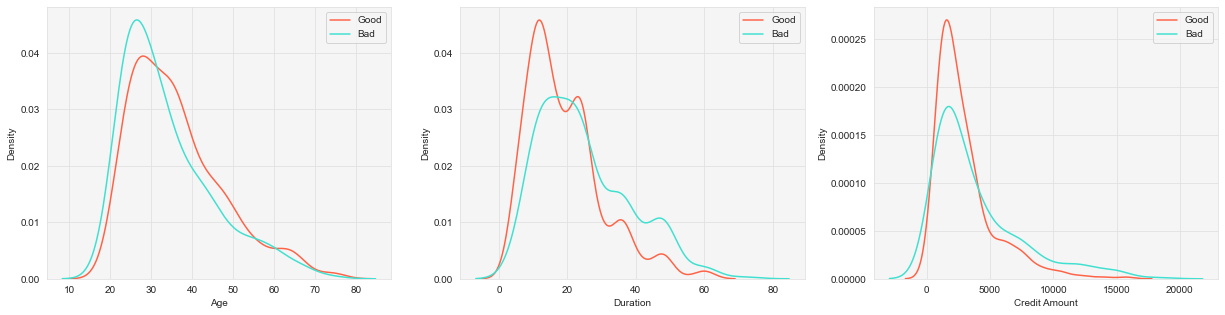

In [491]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

sns.kdeplot(ax=axes[0], data=good, x = "Age", label = "Good")
sns.kdeplot(ax=axes[0], data=bad, x = "Age", label = "Bad")
axes[0].legend()

sns.kdeplot(ax=axes[1], data=good, x = "Duration", label = "Good")
sns.kdeplot(ax=axes[1], data=bad, x = "Duration", label = "Bad")
axes[1].legend()

sns.kdeplot(ax=axes[2], data=good, x = "Credit Amount", label = "Good")
sns.kdeplot(ax=axes[2], data=bad, x = "Credit Amount", label = "Bad")
axes[2].legend()

plt.show()


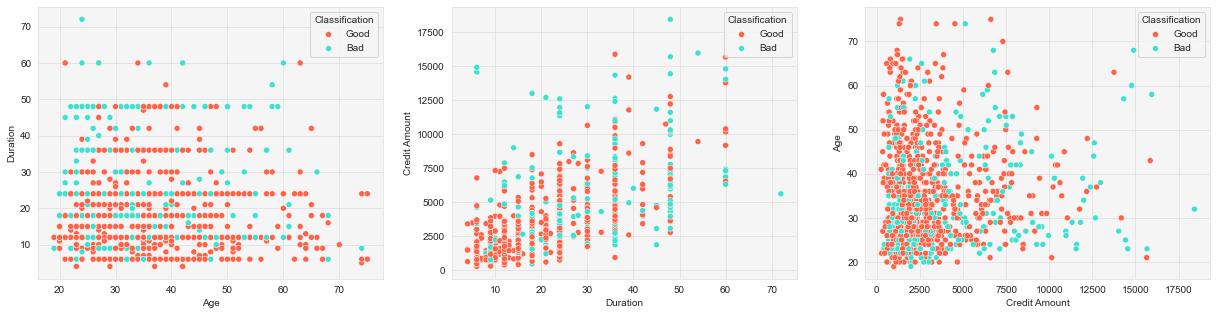

In [492]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
sns.scatterplot(ax=axes[0], data=df_copy2, x = "Age", y = "Duration", hue = "Classification")
sns.scatterplot(ax=axes[1], data=df_copy2, x = "Duration", y = "Credit Amount", hue = "Classification")
sns.scatterplot(ax=axes[2], data=df_copy2, x = "Credit Amount", y = "Age", hue = "Classification")
plt.show()

On the plot above we have a scatter plot for all pairs of continuous features with different colors for "Good" and "Bad" label. We can observe some linear realtionship between credit amount and duartion variables, which will be further examined using correlation matrix. Remaining two plots do not show a noticable positive or negative relationship. 

In [493]:
num_target = numerical_col

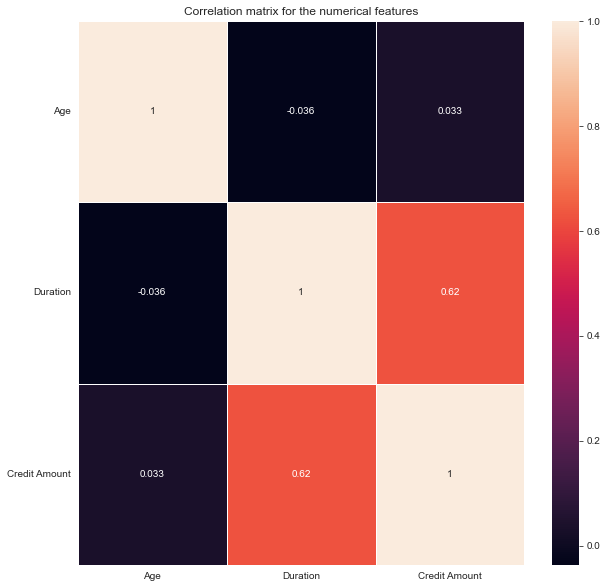

In [494]:
corr = df[numerical_col].corr()

fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_col)
ax.set_yticklabels(labels=numerical_col, rotation=0)
ax.set_title("Correlation matrix for the numerical features")
plt.show()

After computing the correlation matrix we can see that there in fact is some linear positive relationship for 'Duration' and 'Credit Amount' (0.62), however it is not very strong (0.62 < 0.70). Therefore I have decided to keep all 3 continuous variables. The correlation for other two pairs is very small. 

Now I will examine the boxplots above to hopefully find some features with good discriminative ablilities. 


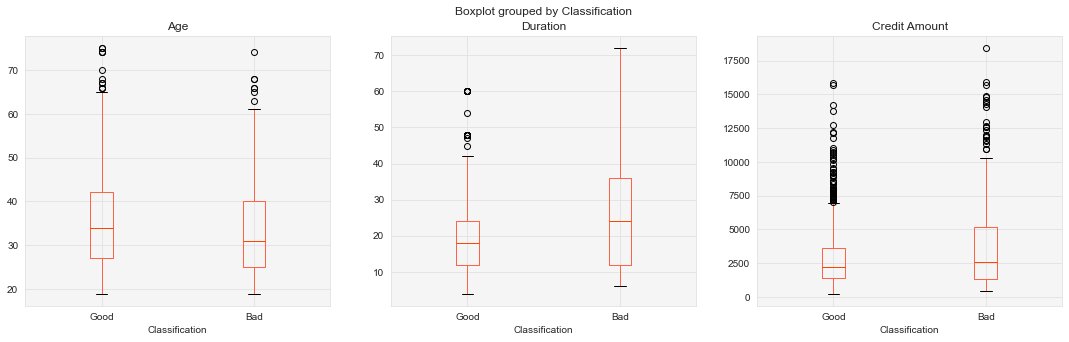

In [495]:
fig, PlotCanvas= plt.subplots(nrows=1, ncols=len(numerical_col), figsize=(18,5))
for PredictorCol , i in zip(numerical_col, range(len(numerical_col))):
    df_copy2.boxplot(column=PredictorCol, by='Classification', figsize=(5,5),  ax=PlotCanvas[i])

* For 'Age' vs 'Classification' boxplots we do not see many differences, the boxes are on similar levels and also the median is very similar. This means that people whose loan was rejected and whose loan was approved were similar in this category. Out of these 3 features this one displays the poorest discriminative ablility.

* For 'Duration' vs 'Classification' we see some more differences. For applicants classified as 'Good' the IQR is smaller compared to the one for 'Bad' applicants. However they still overlap, which means we can not distinguish 'Bad' and 'Good' bank custumers based on this feature only.

* For 'Credit Amount' vs 'Classification' there are noticeably more outliers in both groups. Here the IQR of "Good" group is also smaller compared to IQR of the "Bad" group. 

**Since for all 3 pairs of plots the boxes overlap, there are no features with very good discriminative ablilities.**

### 2. Categorical Data

Below are the mosaic plots for categorical data. 

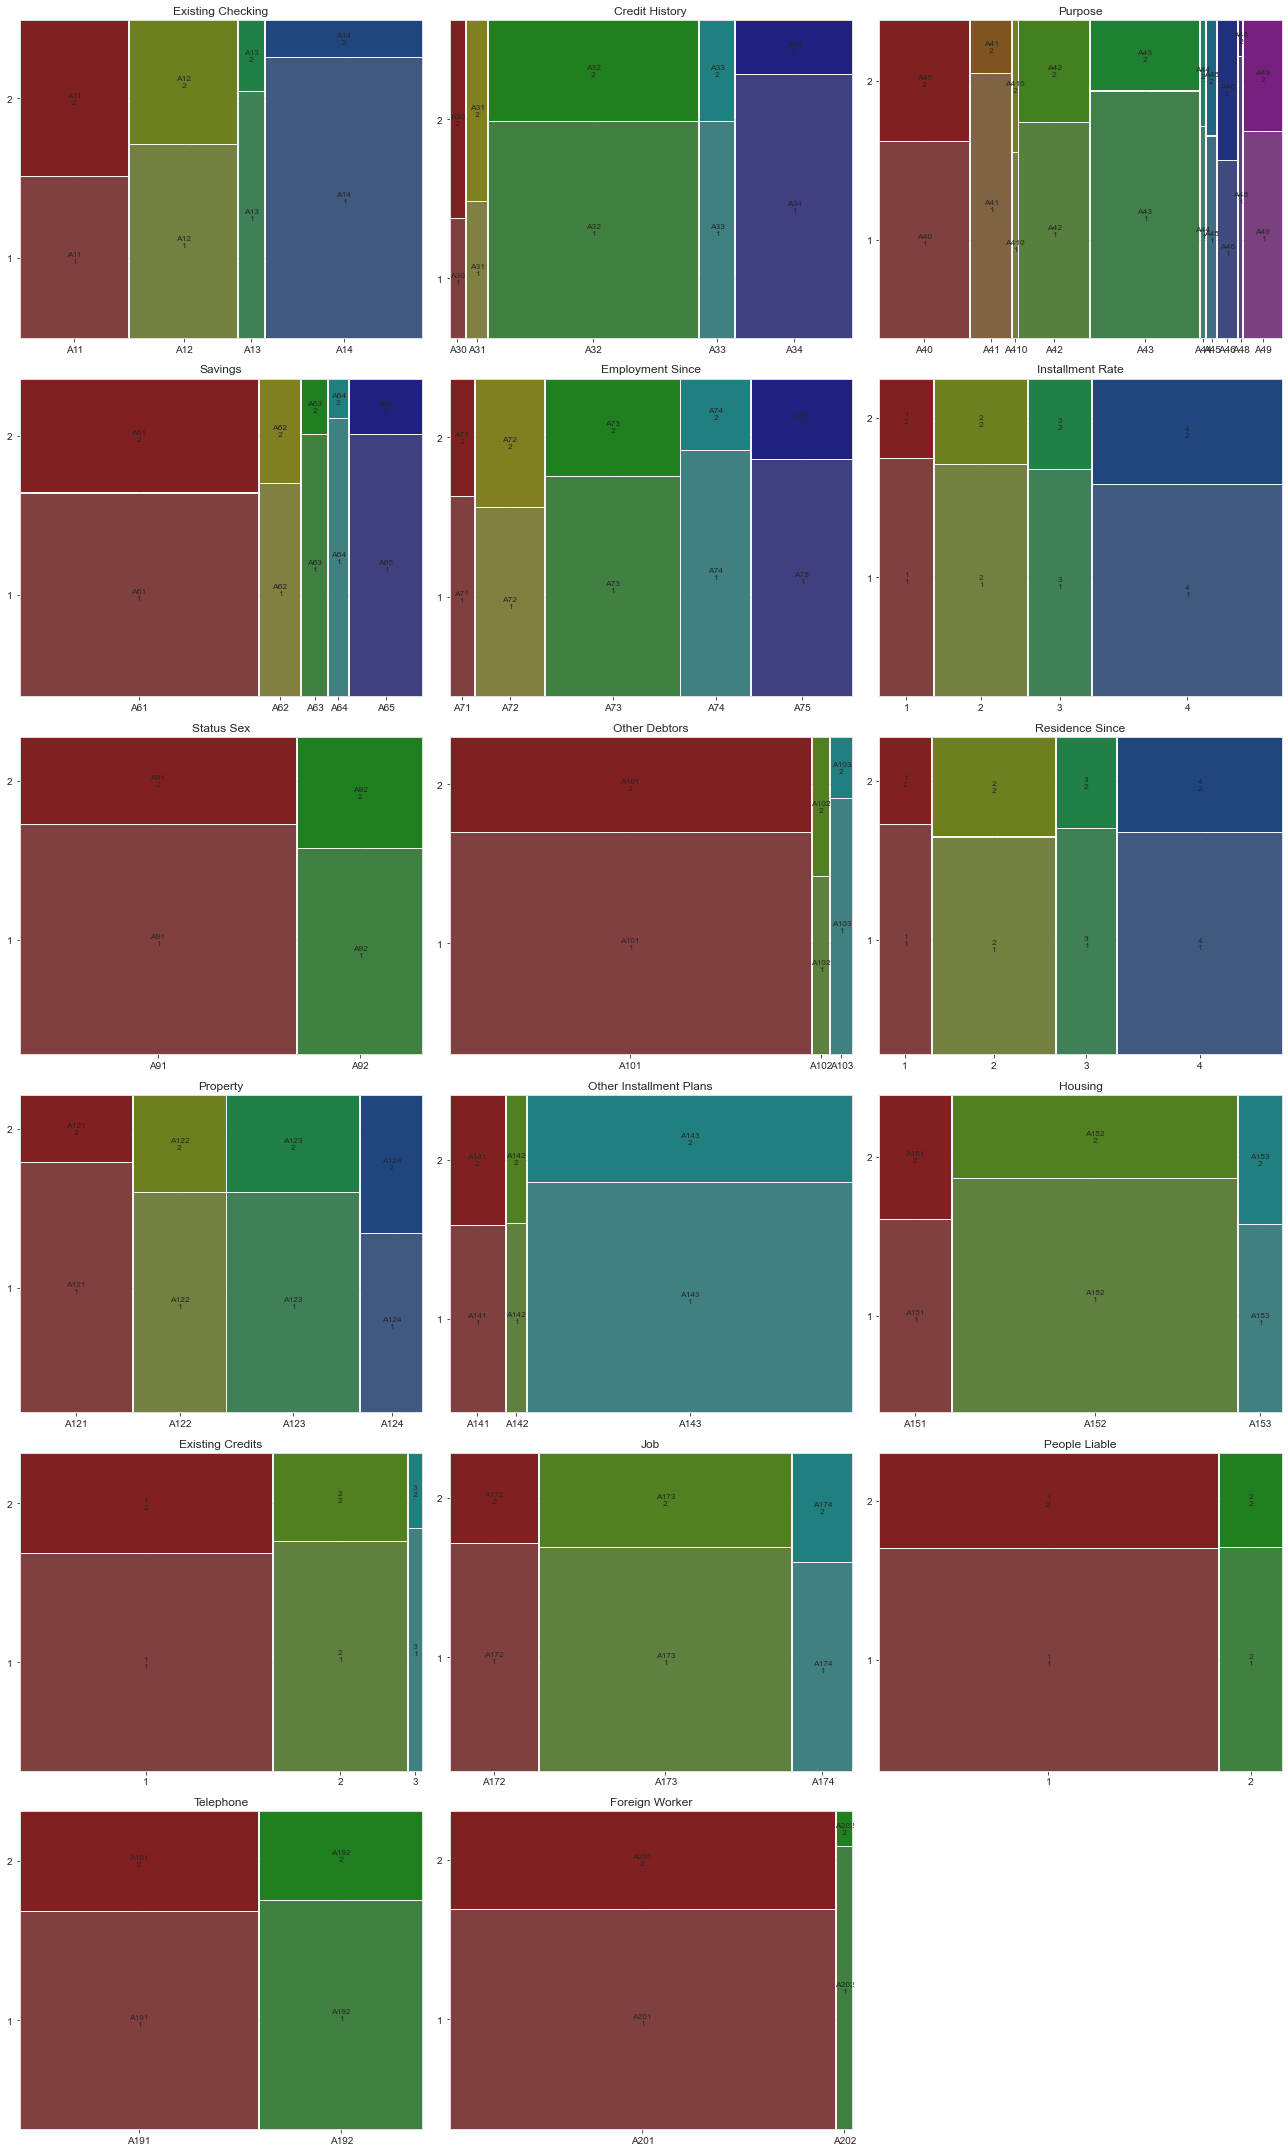

In [496]:
fig, axes = plt.subplots(6, 3, figsize=(18, 6 * 5))  
axes = axes.flatten()  

for idx, col in enumerate(column_names[:-1]):
    crosstable = pd.crosstab(df_comb[col], df_comb['Classification'])
    mosaic(crosstable.stack(), title=str(col), ax=axes[idx])

# Hide any unused subplots
for idx in range(len(column_names) - 1, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout()
plt.show()

Mosaic plots, which present the most visible differences in ratio between different categories:

* **Existing Checking** : a lot more applicants classified as ”Bad” had below 0 DM (A11) saved in their checking account compared to ”Good” group.  Also a lot more ”Good” customers do not have any checking account (A14) compared to ”Bad” ones.

* **Credit History**
* **Savings**  
* **Purpose**

Because for these features ratios differ the most, they can be considered as best predictors for class labels.


On the other hand, there were features with very small differences in ratio. Such as **Telephone**,
**Job**, **People Liable**. These features do not possess discriminative abilities.

Similar conclusions can be drawn using bar plots.


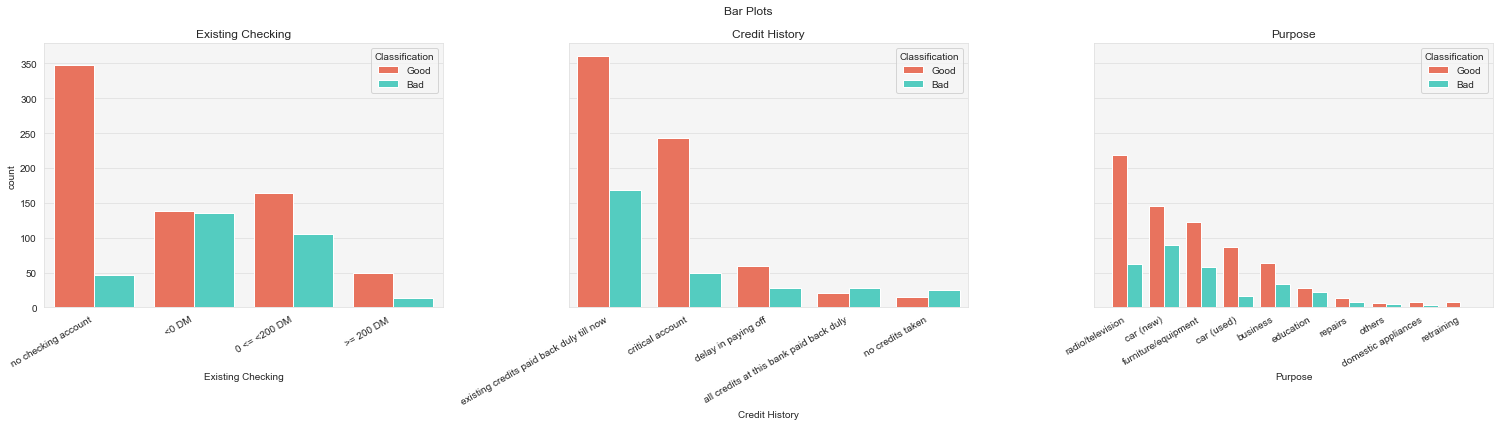

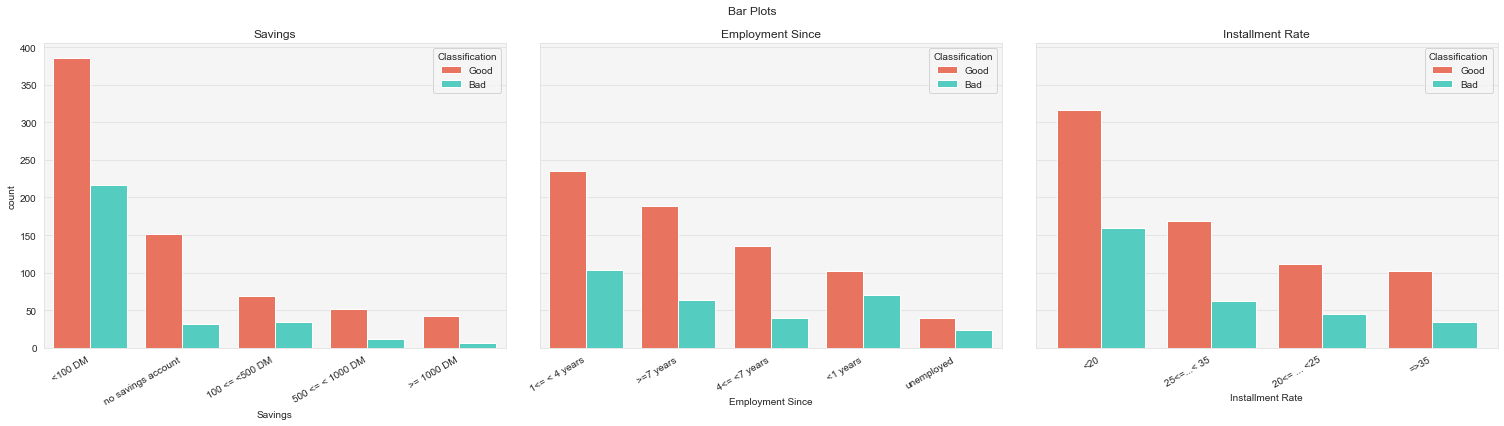

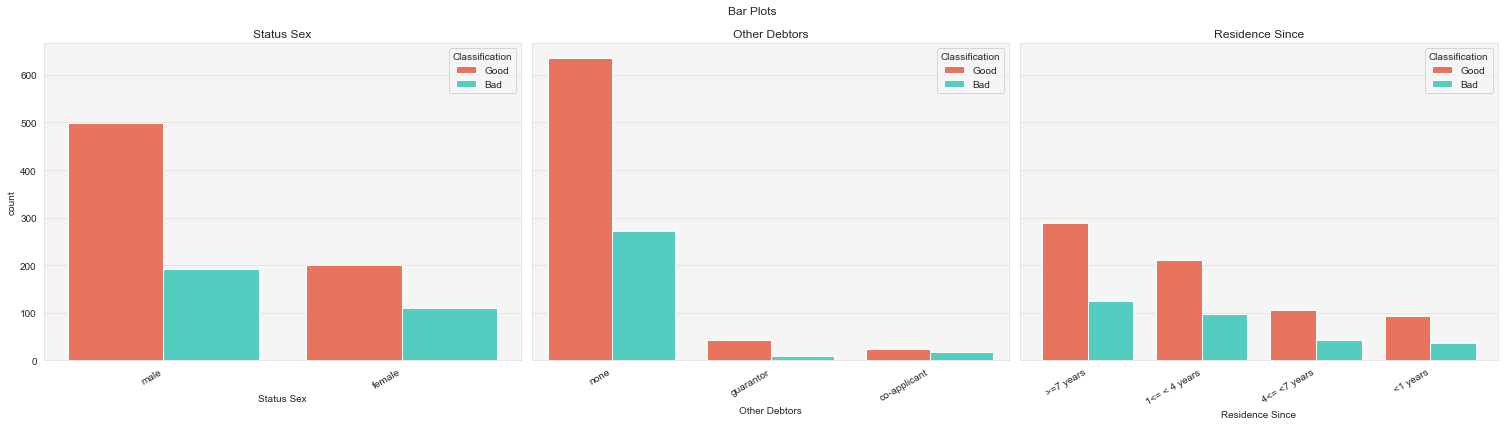

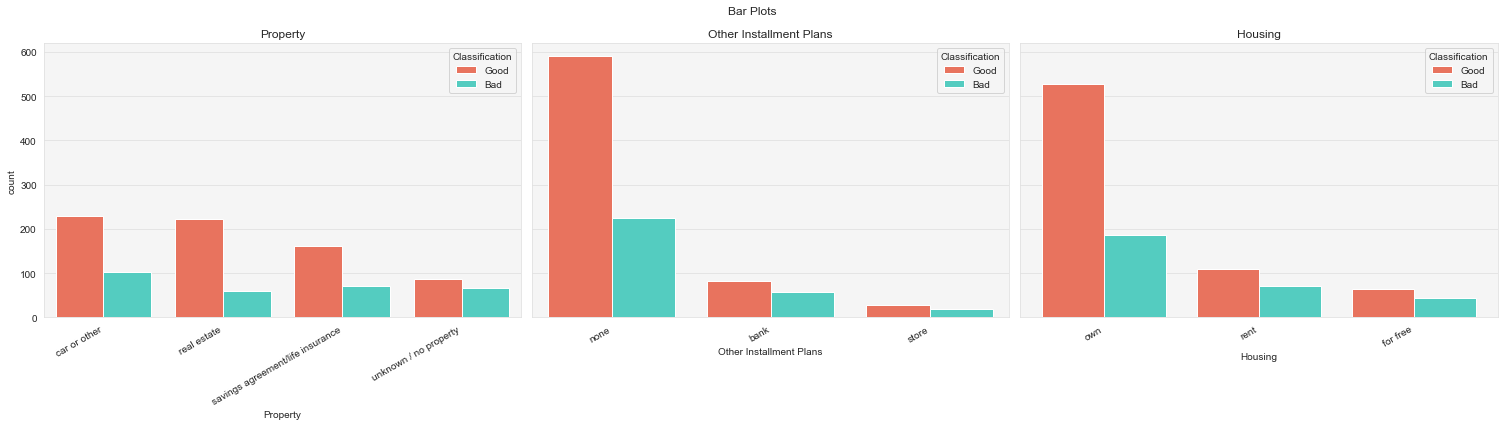

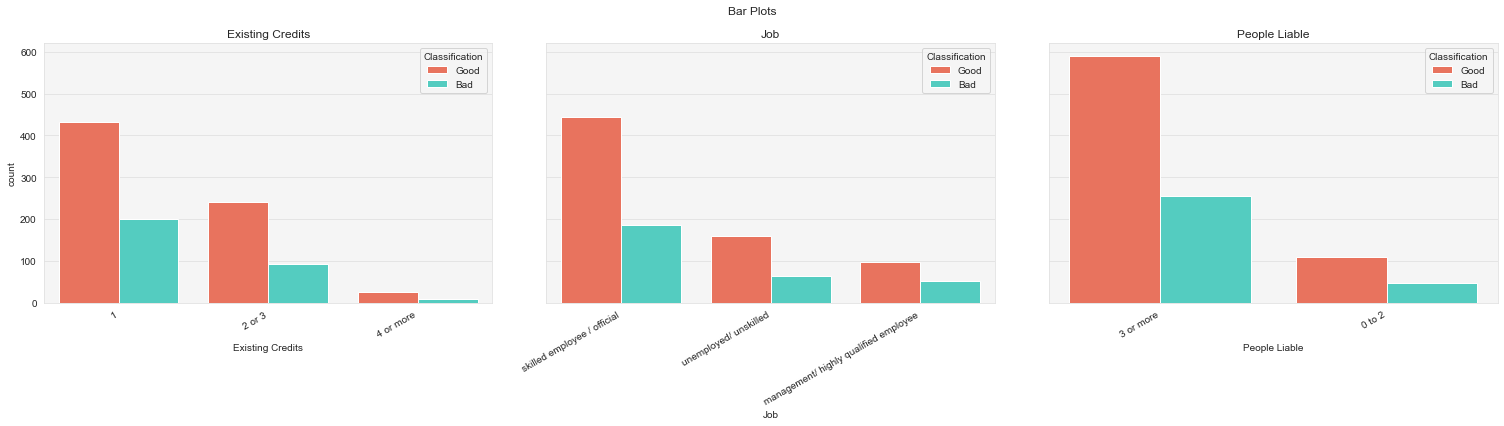

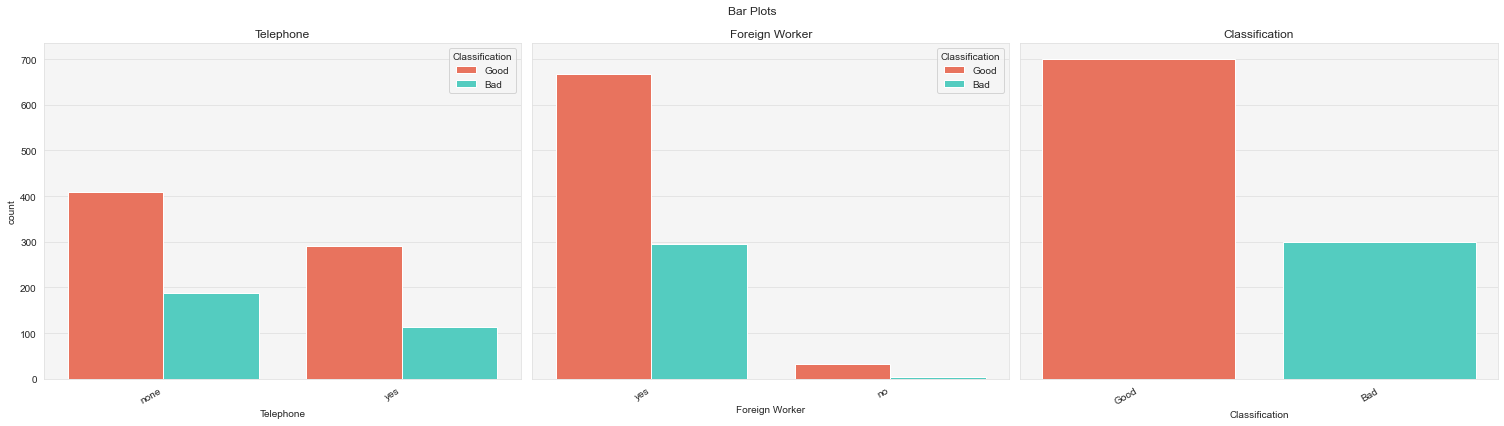

In [497]:
def plot_3_barplots_hue(chunk, data):

    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
    fig.suptitle('Bar Plots')

    sns.countplot(ax=axes[0], x=chunk[0] , data = data, hue = "Classification",order = data[chunk[0]].value_counts().index)
    axes[0].set_title(chunk[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[1], x=chunk[1] , data = data, hue = "Classification", order = data[chunk[1]].value_counts().index)
    axes[1].set_title(chunk[1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[2], x=chunk[2] , data = data, hue = "Classification", order = data[chunk[2]].value_counts().index)
    axes[2].set_title(chunk[2])
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, ha="right")
    
    plt.tight_layout()
    plt.plot()

for i in chunks:
    plot_3_barplots_hue(i, df_copy2)

In case of these barplots we can check the ratio of each bar pair to see if a given feature effects the response variable. For example we can see that for  'Telephone' variable the ratio is very similar for each pair of bars. ('Bad' is around half the size of 'Good' bar). This suggest that these features do not effect the target variable 'Classification'.

Similar ratio: 
* **Telephone**, **Job**, **Existing Credits**, **People Liable**, **Residence Since**, **Installment Rate**.

Noticable differences in ratio:
* **Existing Checking**, **Credit History** , **Purpose**, **Property**, **Employment Since**.

Most propably features with noticable differences in ration will be best predictors, in other words they have good discriminative ablilities. I will check that in feature selection section.

## Feature Selection

### 1. Continuous Features - Student's t-Test

To assess the relationship between continuous features and a binary categorical target variable, we use the Student's t-test. This test helps determine whether the means of a continuous feature differ significantly between the two categories of the target variable.


**Test Assumptions:**

1. **Independence:** Observations in each group are independent of each other.
2. **Normality:** The continuous feature should be approximately normally distributed within each group. For large sample sizes, this assumption is less critical due to the Central Limit Theorem.
3. **Equal Variance:** The variances of the continuous feature should be approximately equal across the two groups (homogeneity of variance).

**Hypotheses:**

- **Null Hypothesis ($H_0$):** There is no significant difference in the means of the continuous feature between the two categories of the target variable. In other words, the feature does not contribute to distinguishing between the two groups.
- **Alternative Hypothesis ($H_1$):** There is a significant difference in the means of the continuous feature between the two categories of the target variable.


In [498]:
def t_test(data, target, feature_list):

    p_values = []
    # Assume binary classification 
    class_labels = data[target].unique()
    if len(class_labels) != 2:
        raise ValueError("The target variable should have exactly two classes for t-test.")
    class1 = class_labels[0]
    class2 = class_labels[1]
    
    for feature in feature_list:
        class1_data = data[data[target] == class1][feature]
        class2_data = data[data[target] == class2][feature]
        t_test_result = ttest_ind(class1_data, class2_data)
        p_values.append(t_test_result.pvalue)
    
    results = pd.DataFrame({
        'Feature': feature_list,
        'p-value': p_values
    })
    return results

t_test_results = t_test(data=df_copy2, target='Classification', feature_list=numerical_col)
t_test_results

,Feature,p-value
0,Age,3.925339e-03
1,Duration,6.488050e-12
2,Credit Amount,8.797572e-07


Here we can see the results. All of the p-values are below 0.05, therefore we can reject the null hypothesis. This suggests that each continuous feature is corralated with target variable.

The decision is to keep all of the continuous features : 'Age', 'Duration', 'Credit Amount'.

### 2. Categorical Features - Chi-Square Test

To evaluate the relationship between categorical features and a categorical target variable, we use the Chi-Square test. This test assesses whether there is a significant association between two categorical variables.

**Test Assumptions:**

1. **Independence:** The observations should be independent of each other.
2. **Sample Size:** The sample size should be sufficiently large. Each cell in the contingency table should have an expected frequency of at least 5 for the Chi-Square approximation to be valid.
3. **Categorical Data:** Both variables should be categorical. If any variable is numerical, it should be binned into categories before applying the test.

**Hypotheses:**

- **Null Hypothesis ($H_0$):** There is no significant association between the categorical feature and the target variable. In other words, the distribution of the feature's categories is independent of the target variable's categories.
- **Alternative Hypothesis ($H_1$):** There is a significant association between the categorical feature and the target variable. The distribution of the feature's categories is dependent on the target variable's categories.

In [499]:
categorical_col = column_names[:-1]

In [500]:
def Chisq_test(data, target, feature_list):
    
    p_values=[]
    corr = []

    for feature in feature_list:
        CrossTabResult=pd.crosstab(index=data[target], columns=data[feature])
        ChiSqResult = chi2_contingency(CrossTabResult)
        p_values.append(ChiSqResult[1])
        if ChiSqResult[1] < 0.05:
            corr.append("Yes")
        else:
            corr.append("No")

    dict_ = {'Feature' : feature_list, 'p-value': p_values, 'Is_corr': corr}
    Chi_df = pd.DataFrame(dict_) 
        
    return(Chi_df)

Chisq_result = Chisq_test(data=df_copy2, target='Classification', feature_list=categorical_col)

In [501]:
Chisq_result.sort_values(by='p-value')

,Feature,p-value,Is_corr
0,Existing Checking,1.218902e-26,Yes
1,Credit History,1.279187e-12,Yes
3,Savings,2.761214e-07,Yes
9,Property,2.858442e-05,Yes
11,Housing,1.116747e-04,Yes
2,Purpose,1.157491e-04,Yes
4,Employment Since,1.045452e-03,Yes
10,Other Installment Plans,1.629318e-03,Yes
16,Foreign Worker,1.583075e-02,Yes
6,Status Sex,2.073991e-02,Yes


Here we have the results for Chi-Square test, we can see that some features can be rejected. 

In [502]:
rejected_features = list(Chisq_result[Chisq_result['Is_corr']== "No"]['Feature'])
selected_features = list(Chisq_result[Chisq_result['Is_corr']== "Yes"]['Feature'])

print("There are ",  len(rejected_features),"rejected features: " ,rejected_features)
print("There are ", len(selected_features) ,"selected_features: ", selected_features)

There are  6 rejected features:  ['Installment Rate', 'Residence Since', 'Existing Credits', 'Job', 'People Liable', 'Telephone']
There are  11 selected_features:  ['Existing Checking', 'Credit History', 'Purpose', 'Savings', 'Employment Since', 'Status Sex', 'Other Debtors', 'Property', 'Other Installment Plans', 'Housing', 'Foreign Worker']


The rejected features confirm our conclusions based on paired barplots (in section Bivariate Analysis).

## Encoding

First I will load dataframe with the selected features.

In [503]:
df_comb_before_encoding = df_comb.copy()

In [504]:
selected = selected_features + numerical_col + ["Classification"]
selected

['Existing Checking',
 'Credit History',
 'Purpose',
 'Savings',
 'Employment Since',
 'Status Sex',
 'Other Debtors',
 'Property',
 'Other Installment Plans',
 'Housing',
 'Foreign Worker',
 'Age',
 'Duration',
 'Credit Amount',
 'Classification']

In [505]:
df_comb = df_comb[selected]

Now I will divide features into nominal, ordinal, numeric and encode them accordingly. Then I will implement the following strategy:

1. **Ordinal Features:** Mapped ordinal features to numeric values.
2. **Nominal Features:** Used dummy encoding to represent nominal features with N-1 binary variables.
3. **Target Variable:** Transformed the ‘Classification’ column into binary values, with ‘Good’ as 0 and ‘Bad’ as 1 to highlight the minority class. 

In [506]:
nominal = ["Housing", "Other Installment Plans", "Property", "Other Debtors", "Status Sex", "Purpose", "Credit History", 'Foreign Worker']

In [507]:
ordinal = list(set(df_comb.columns) - set(nominal))

In [508]:
ordinal

['Savings',
 'Age',
 'Existing Checking',
 'Classification',
 'Credit Amount',
 'Employment Since',
 'Duration']

In [509]:
df_comb[nominal]

,Housing,Other Installment Plans,Property,Other Debtors,Status Sex,Purpose,Credit History,Foreign Worker
0,A152,A143,A121,A101,A91,A43,A34,A201
1,A152,A143,A121,A101,A92,A43,A32,A201
2,A152,A143,A121,A101,A91,A46,A34,A201
3,A153,A143,A122,A103,A91,A42,A32,A201
4,A153,A143,A124,A101,A91,A40,A33,A201
...,...,...,...,...,...,...,...,...
995,A152,A143,A121,A101,A92,A42,A32,A201
996,A152,A143,A122,A101,A91,A41,A32,A201
997,A152,A143,A123,A101,A91,A43,A32,A201
998,A153,A143,A124,A101,A91,A43,A32,A201


In [510]:
# Binarize 'Classification' to : 0 = 'bad' credit; 1 = 'good' credit
df_comb['Classification'].replace([1,2], [0,1], inplace=True)

df_comb['Employment Since'].replace(["A71", "A72", "A73", "A74", "A75"],[0,1,2,3,4], inplace = True)

df_comb['Savings'].replace(["A61", "A62", "A63", "A64", "A65"],[1,2,3,4,0], inplace = True)

df_comb['Existing Checking'].replace(["A11", "A12", "A13", "A14"],[1,2,3,0], inplace = True)

In [511]:
df_comb[ordinal]

,Savings,Age,Existing Checking,Classification,Credit Amount,Employment Since,Duration
0,0,67,1,0,1169,4,6
1,1,22,2,1,5951,2,48
2,1,49,0,0,2096,3,12
3,1,45,1,0,7882,3,42
4,1,53,1,1,4870,2,24
...,...,...,...,...,...,...,...
995,1,31,0,0,1736,3,12
996,1,40,1,0,3857,2,30
997,1,38,0,0,804,4,12
998,1,23,1,1,1845,2,45


In [512]:
# Transforming categorical variables using dummies
df_comb_nominal=pd.get_dummies(df_comb[nominal], dtype=int)
df_comb_nominal

,Housing_A151,Housing_A152,Housing_A153,Other Installment Plans_A141,Other Installment Plans_A142,Other Installment Plans_A143,Property_A121,Property_A122,Property_A123,Property_A124,...,Purpose_A46,Purpose_A48,Purpose_A49,Credit History_A30,Credit History_A31,Credit History_A32,Credit History_A33,Credit History_A34,Foreign Worker_A201,Foreign Worker_A202
0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
996,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
997,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
998,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [513]:
df_comb =  pd.concat([df_comb_nominal, df_comb[ordinal] ], axis = 1)

df_comb.columns

Index(['Housing_A151', 'Housing_A152', 'Housing_A153',
       'Other Installment Plans_A141', 'Other Installment Plans_A142',
       'Other Installment Plans_A143', 'Property_A121', 'Property_A122',
       'Property_A123', 'Property_A124', 'Other Debtors_A101',
       'Other Debtors_A102', 'Other Debtors_A103', 'Status Sex_A91',
       'Status Sex_A92', 'Purpose_A40', 'Purpose_A41', 'Purpose_A410',
       'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45',
       'Purpose_A46', 'Purpose_A48', 'Purpose_A49', 'Credit History_A30',
       'Credit History_A31', 'Credit History_A32', 'Credit History_A33',
       'Credit History_A34', 'Foreign Worker_A201', 'Foreign Worker_A202',
       'Savings', 'Age', 'Existing Checking', 'Classification',
       'Credit Amount', 'Employment Since', 'Duration'],
      dtype='object')

## Preprocessing and Class Imbalance Handling

### 1. Spliting Data into Training and Test

In [514]:
# target
Target = 'Classification'

# all column with predictors
Predictors = list(df_comb.columns)
Predictors.remove('Classification')

print("Number of predictors :" ,len(Predictors))

Number of predictors : 38


In [515]:
X = df_comb[Predictors].values
y = df_comb[Target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_raw = X_train
X_test_raw = X_test

### 2. Scaling 

Scaling is a crucial preprocessing step for ensuring that all features contribute equally to the model’s performance, especially when features have different units or scales. Standardization is commonly used to transform features so that they have a mean of 0 and a standard deviation of 1. This technique ensures that each feature contributes proportionately to the model, preventing features with larger scales from dominating those with smaller scales.


In [516]:
PredictorScaler=StandardScaler()
X_train = PredictorScaler.fit_transform(X_train)
X_test = PredictorScaler.transform(X_test)

### 3. Handling Class Imbalance: ADASYN Sampling

**ADASYN (Adaptive Synthetic Sampling Approach for Imbalanced Learning)** is a technique designed to address class imbalance by generating synthetic samples for the minority class, thereby balancing the class distribution in the training set. 

* Unlike simple oversampling methods, ADASYN focuses on generating synthetic samples in the feature space where the minority class is underrepresented and harder to classify, adapting the sampling rate based on the difficulty of classifying minority instances.

* It helps reduce the bias towards the majority class.

* It is essential to apply ADASYN only to the training data and not to the validation or test sets. This ensures that the validation and test data remain representative of the original distribution, allowing for an accurate evaluation of model performance.


In [517]:
ada = ADASYN()

X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

print("Shape of the balanced ADASYN dataset is: ", X_train_ada.shape)

pos_ratio = y_train_ada[y_train_ada==1].shape[0]/y_train_ada.shape[0]
neg_ratio = y_train_ada[y_train_ada==0].shape[0]/y_train_ada.shape[0]

print("Proportion of positive samples in the balanced training set: " ,pos_ratio)
print("Proportion of negative samples in the balanced training set: " ,neg_ratio)

Shape of the balanced ADASYN dataset is:  (983, 38)
Proportion of positive samples in the balanced training set:  0.5005086469989827
Proportion of negative samples in the balanced training set:  0.49949135300101727


### Training and testing functions

In [518]:
def conf_matrix_plot_list(conf_matrix_list, model_name_list): 

    """" Function plots 2x2 grid with 4 confusion matrices """
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    sns.heatmap(conf_matrix_list[0], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g", ax=ax[0,0])
    ax[0,0].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[0,0].set_xlabel("predicted")
    ax[0,0].set_ylabel("actual")
    ax[0,0].set_title(str("Confusion matrix " + model_name_list[0]))

    sns.heatmap( conf_matrix_list[1], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g", ax=ax[0,1])
    ax[0,1].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[0,1].set_xlabel("predicted")
    ax[0,1].set_ylabel("actual")
    ax[0,1].set_title(str("Confusion matrix " + model_name_list[1]))

    sns.heatmap(conf_matrix_list[2], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g", ax=ax[1,0])
    ax[1,0].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[1,0].set_xlabel("predicted")
    ax[1,0].set_ylabel("actual")
    ax[1,0].set_title(str("Confusion matrix " + model_name_list[2]))

    sns.heatmap( conf_matrix_list[3], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g",ax=ax[1,1])
    ax[1,1].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[1,1].set_xlabel("predicted")
    ax[1,1].set_ylabel("actual")
    ax[1,1].set_title(str("Confusion matrix " + model_name_list[3]))
    plt.show()

def conf_matrix_plot(conf_matrix, model_name): #confusion_matrix_list, _model_name_list

    " Function displays confusion matrix as heatmap"

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g")
    ax.set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax.set_xlabel("predicted")
    ax.set_ylabel("actual")
    ax.set_title(str("Confusion matrix " + model_name))
    plt.show()
     

def plot_roc(roc, roc_auc, model_name):

    " Function plots roc curve"

    fig, ax = plt.subplots(figsize=(7, 5))
    plt.plot(roc[0],roc[1],label="auc="+str(roc_auc))
    plt.plot([0,1], [0,1], color = "black")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name)
    plt.legend(loc=4)
    plt.show()


def trainClassifier(X_train, y_train, model_name, classifier, params):

    " Function for training a classifier and finding best parameters"
    
    # performing GridSearch with 10 fold CV to tune the model
    kf = StratifiedKFold(10)
    train_scores = []
    best_score = 0
        
    for config in ParameterGrid(params):
        train_scores_run = []
        counts = []
        for train_indices, valid_indices in kf.split(X_train, y_train):
            counts.append(len(train_indices))
            X_train_kf = X_train[train_indices]
            y_train_kf = y_train[train_indices]
            X_valid_kf = X_train[valid_indices]
            y_valid_kf = y_train[valid_indices]

            model = classifier(**config)
            model.fit(X_train_kf, y_train_kf)
            y_hat = model.predict(X_valid_kf)
            train_score = accuracy_score(y_valid_kf, y_hat) # fbeta 2 
            train_scores_run.append(train_score)


        if np.average(train_scores_run, weights=counts) > best_score:
            best_score = np.average(train_scores_run, weights=counts)
            best_config = config

        train_scores.append(np.average(train_scores_run, weights=counts))

    output_df = pd.DataFrame(data = [[model_name, best_config ,best_score]], \
        columns=["model_name", "parameters", "training_score (acc)"])

    return output_df, best_config


def testClassifier(X_train, y_train, X_test, y_test, classifier, best_params, proba=False):
    
    """ Function for testing the classifier, 
    returns: output_df :  dataframe with scores
            roc : a tuple with [false positive , true positive]
            roc_auc: the auc value
            conf_matrix: confusion matrix"""

    best_model = classifier(**best_params)
    best_model.fit(X_train, y_train)

    
    y_hat = best_model.predict(X_test)

    # f1 score
    f1_test = f1_score(y_test, y_hat)
    
    # f2 score
    f2_test = fbeta_score(y_test, y_hat, beta=2)

    # Accuracy
    accuracy_test = accuracy_score(y_test, y_hat)

    conf_matrix = confusion_matrix(y_test, y_hat)

    tn, fp, fn, tp = conf_matrix.ravel()
    cost = 0 * tn + 1 * fp + 5* fn + 0 * tp

    # Specificity
    specificity = tn / (tn+fp)

    # Sensitivity
    sensitivity = tp / (tp + fn)


    if proba == False:
        y_score = best_model.decision_function(X_test)
    else:
        y_score = best_model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    roc = [fpr, tpr] 

    output_df = pd.DataFrame(data=[[f1_test, f2_test, accuracy_test, specificity, sensitivity, cost]],\
        columns=["f1_test", "f2_test", "accuracy_test" ,"specificity", "sensitivity","cost"])
    
    return output_df, roc, roc_auc, conf_matrix


def model_results(X_train, y_train, X_test, y_test, model_name, classifier, params, proba):

    " Function trains and test a classifier, prepares the results "

    df_res1, best_params = trainClassifier(X_train, y_train, model_name , classifier , params)
    df_res2, roc, roc_auc, conf_matrix = testClassifier(X_train, y_train, X_test, y_test, classifier, best_params, proba=proba)
    df_full = pd.concat([df_res1, df_res2 ], axis = 1)

    return df_full, conf_matrix, roc, roc_auc


## Logistic Regression

### 1. Calculating feature importance

The simplest way to calculate feature importance in logistic regression is using the model’s coefficients. The coefficients represent the change in the log odds for a one-unit change in the predictor variable. Larger absolute values indicate a stronger relationship between the predictor and the target variable.

Using this way of feature selection it is important to mention that the data should be scaled, since the model may give higher coefficients (thus higher importance) to the features with larger values, even if they are not necessarily more important.
When the features are standardized, the magnitude of the coefficients in logistic regression directly reflects the importance of each feature.
The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.


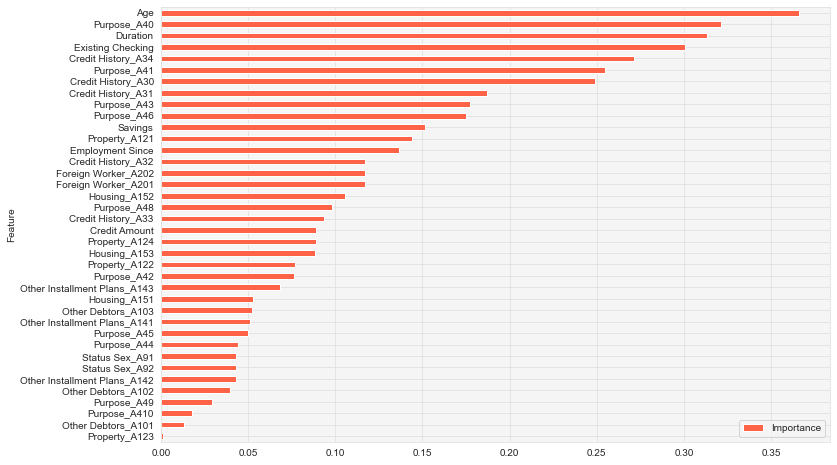

In [519]:
def importance_plot(model, X_train, y_train):
    
    model.fit(X_train, y_train)
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature': Predictors, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))
    ax.legend(loc='lower right')
    plt.show()

    return feature_importance

LR = LogisticRegression()
LR_FI = importance_plot(LR, X_train, y_train)


### 2. Choosing feature subsets based on Importance Plots

Based on the importance plot, I selected the top 7 most significant features with coefficients greater than 0.2. This decision was guided by a visual assessment, revealing a clear distinction between these top features and the rest. 

The chosen features include: 
* 'Age', 
* 'Purpose', 
* 'Duration', 
* 'Existing_Checking', 
* 'Credit_History'. 

These top 7 features will be compared against the full set of features with and without ADASYN sampling.

In [520]:
# top 7 features subset
top7_LR = list(LR_FI.sort_values(by='Importance', ascending=False).head(7)['Feature'])

X_top7_LR = df_comb[top7_LR].values
X_train_top7_LR, X_test_top7_LR, y_train_top7_LR, y_test_top7_LR = train_test_split(X_top7_LR , y, test_size=0.3, random_state=42)
X_train_top7_LR = PredictorScaler.fit_transform(X_train_top7_LR)
X_test_top7_LR = PredictorScaler.transform(X_test_top7_LR)

# with ADASYN
X_train_top7_LR_ada, y_train_top7_LR_ada = ada.fit_resample(X_train_top7_LR,y_train_top7_LR)


### 3. Logistic Regression results

Before presenting the results, I performed a final step in the classification process: conducting a grid search. Specifically, for logistic regression, I used grid search to find the best C parameter, which controls the regularization strength in the model. This parameter helps balance the trade-off between fitting the training data well and maintaining a model that generalizes well to new, unseen data.

The logistic regression results (as well as KNN and Decision Trees results) are summarized as follows:

- **Summary Table** 
- **Confusion Matrix** 
- **ROC Curve and AUC Comparison** 


In [521]:
param_grid =    {
    'C' : np.logspace(-4, 4, 20)}

df_full_LG_top7, conf_matrix_LG_top7, roc_LG_top7, roc_auc_LG_top7= model_results(X_train_top7_LR, y_train_top7_LR, X_test_top7_LR, y_test_top7_LR, "Logistic Regression Top7", LogisticRegression, param_grid, proba=True)
df_full_LG, conf_matrix_LG, roc_LG, roc_auc_LG = model_results(X_train, y_train, X_test, y_test, "Logistic Regression All Features", LogisticRegression, param_grid, proba=True)
df_full_LG_top7_ada, conf_matrix_LG_top7_ada, roc_LG_top7_ada, roc_auc_LG_top7_ada= model_results(X_train_top7_LR_ada, y_train_top7_LR_ada, X_test_top7_LR, y_test_top7_LR, "Logistic Regression Top7 ADASYN", LogisticRegression, param_grid, proba=True)
df_full_LG_ada, conf_matrix_LG_ada, roc_LG_ada, roc_auc_LG_ada = model_results(X_train_ada, y_train_ada, X_test, y_test, "Logistic Regression All Features ADASYN", LogisticRegression, param_grid, proba=True)

LG_summary = pd.concat([df_full_LG_top7, df_full_LG, df_full_LG_top7_ada, df_full_LG_ada], axis = 0)
LG_summary

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,Logistic Regression Top7,{'C': 0.08858667904100823},0.714286,0.231405,0.177665,0.690000,0.923445,0.153846,401
0,Logistic Regression All Features,{'C': 0.08858667904100823},0.735714,0.355556,0.294118,0.710000,0.904306,0.263736,355
0,Logistic Regression Top7 ADASYN,{'C': 0.08858667904100823},0.667463,0.508333,0.594542,0.606667,0.578947,0.670330,238
0,Logistic Regression All Features ADASYN,{'C': 0.00026366508987303583},0.691628,0.519824,0.590000,0.636667,0.631579,0.648352,237


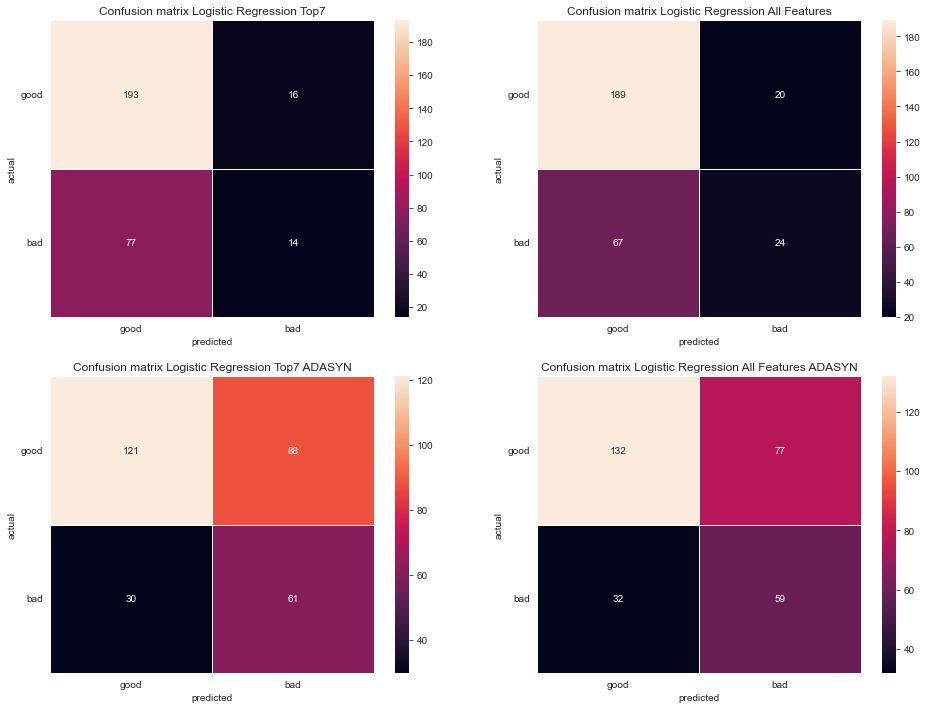

In [522]:
conf_matrix_plot_list([conf_matrix_LG_top7,conf_matrix_LG, conf_matrix_LG_top7_ada, conf_matrix_LG_ada],
                      ["Logistic Regression Top7", "Logistic Regression All Features", "Logistic Regression Top7 ADASYN", "Logistic Regression All Features ADASYN"])

**1. Logistic Regression with Top 7 Features:**

This setup shows the highest rate of false negatives (bad classified as good), which could be costly in a financial context. It shows a relatively high specificity but a low sensitivity, indicating it is better at identifying non-defaults than defaults. The low F1 and F2 scores suggest suboptimal performance in balancing precision and recall.

**2. Logistic Regression with All Features:**

The performance is slightly better in detecting 'bad' cases compared to the Top 7 Features model, but still has a significant number of false negatives. Using all features improves both F1 and F2 scores compared to the Top 7 Features model, reflecting better overall performance. Sensitivity increases, indicating better identification of defaults, though specificity remains high.

**3. Logistic Regression with Top 7 Features and ADASYN:**

With ADASYN, there's a noticeable improvement in identifying 'bad' cases (more true positives) but at the cost of a substantial increase in false positives (good classified as bad). This model benefits significantly from ADASYN sampling, showing a considerable increase in sensitivity and F1/F2 scores. The cost is much lower, indicating a more balanced approach, though the accuracy and specificity are reduced.

**4. Logistic Regression with All Features and ADASYN:**

This setup provides a balance between true positive and true negative rates. It has fewer false negatives compared to other setups, making it more reliable for identifying potential defaulters (high sensitivity), though it also increases false positives. This model shows improved F1 and F2 scores with all features and ADASYN compared to the non-ADASYN versions. The specificity is slightly lower compared to the models without ADASYN, but the overall cost is moderate.

**Summary:**

**1. Impact of Feature Selection:**

* The model with all features generally performs better in terms of accuracy and F1 scores, suggesting that including more features helps in better classification. The Top 7 Features model, while more specific, shows lower overall performance metrics, indicating that it may be missing critical information available in the full feature set.

**2. Effect of ADASYN Sampling:**

* **ADASYN sampling significantly boosts sensitivity**, as evidenced by higher F1 and F2 scores in both Top 7 Features and All Features models. **This suggests ADASYN is effective in improving the model's ability to identify positive instances (defaults)**, although it does come at the cost of lower specificity and accuracy.

**3. Sensitivity vs. Specificity:**

* Sensitivity Improvement: The models with ADASYN show much higher sensitivity compared to those without it. This indicates better performance in identifying defaults, which is critical for minimizing missed credit risks.
* Specificity Trade-off: The increase in sensitivity with ADASYN comes at the expense of specificity, with models showing lower specificity scores. This reflects a trade-off where the model is less effective at correctly identifying non-defaults.

**4. Cost Efficiency:**

* Models using ADASYN have significantly lower costs compared to those without it. This is because ADASYN helps to better balance the classification, reducing the cost of misclassifying defaults as non-defaults.

**5. Model Choice:**

* Best Performing Model: The logistic regression model using all features with ADASYN has the highest F1 and F2 scores, balancing sensitivity and precision, with a moderate cost. This combination appears to be the most effective at identifying defaults while managing the cost of misclassifications.

* For Prioritizing Sensitivity: If the goal is to identify as many defaults as possible, using ADASYN with either feature subset will likely be beneficial, though at the cost of reduced specificity.

* For Balanced Performance: The logistic regression model with all features and ADASYN strikes a balance between accuracy, sensitivity, and cost, making it a strong candidate for scenarios where identifying defaults is crucial but managing overall classification performance is also important.


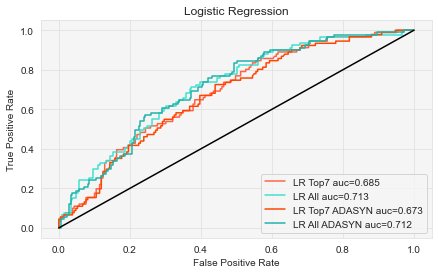

In [523]:
labels = ["LR Top7",  "LR All", "LR Top7 ADASYN", "LR All ADASYN"]
rocs = [roc_LG_top7, roc_LG, roc_LG_top7_ada, roc_LG_ada]
aucs = [roc_auc_LG_top7,roc_auc_LG, roc_auc_LG_top7_ada, roc_auc_LG_ada]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression")
plt.legend(loc=4)
plt.show()

* The best model in terms of AUC is the Logistic Regression with all features, without ADASYN. This indicates that using all available features provides the best predictive performance.
* ADASYN slightly decreases the AUC in both feature settings, suggesting a trade-off between balancing the dataset and maintaining predictive accuracy.
* Overall, these results highlight the importance of feature selection and the careful application of resampling techniques in optimizing model performance.

## KNN

### 1. Calculating Feature Importance

In order to analyze feature importance for KNN model I have decided to use an embeded method - Lasso regularization. 

In [524]:
skf = StratifiedKFold(n_splits=5)
model  = LassoCV(cv=skf, random_state=42)
model.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % model.alpha_)
print("Best score using built-in LassoCV: %f" %model.score(X_train,y_train))
coef = pd.DataFrame({'Feature': Predictors, 'Importance': model.coef_})

Best alpha using built-in LassoCV: 0.011096
Best score using built-in LassoCV: 0.194832


Lasso picked 22 variables and eliminated the other 16 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

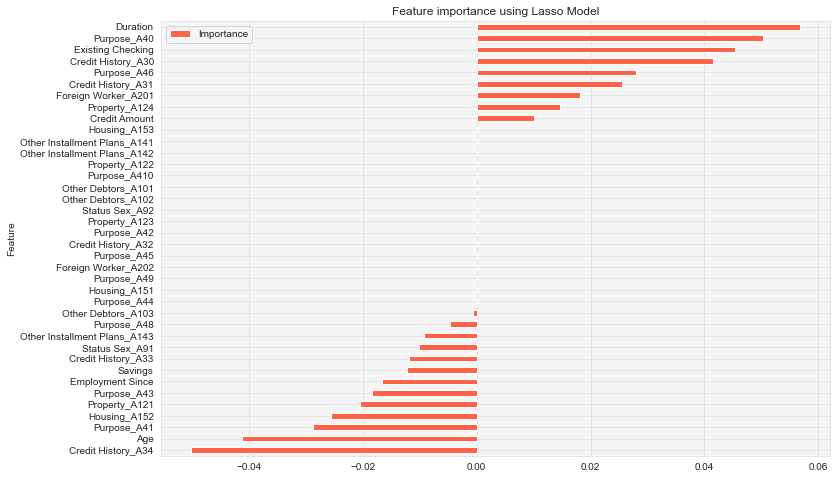

In [525]:
print("Lasso picked " + str(sum(coef['Importance'] != 0)) + " variables and eliminated the other " +  str(sum(coef['Importance'] == 0)) + " variables")
imp_coef = coef.sort_values(by = 'Importance', ascending=True)
# import matplotlib
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))
plt.title("Feature importance using Lasso Model")

The Lasso regularization method identified key features influencing the KNN model. Notably, **Duration** emerged as the most significant feature, followed by **Purpose_A40** and **Existing Checking**, indicating these factors are critical for predicting the target variable. Some features like **Age** and **Credit History_A34** had negative coefficients, suggesting an inverse relationship with the target. Features with near-zero importance were deemed less relevant. Overall Lasso picked 22 out of 38 features. 

### 2. Choosing feature subsets based on Importance Plots

In [526]:
imp_coef['Importance abs'] = abs(imp_coef['Importance'])

KNN_lasso_features = list(imp_coef.sort_values(by='Importance abs', ascending=False).head(23)['Feature'])

# top Lasso feature subset
X_top_Lasso_KNN = df_comb[KNN_lasso_features].values

X_train_Lasso_KNN, X_test_Lasso_KNN, y_train_Lasso_KNN, y_test_Lasso_KNN = train_test_split(X_top_Lasso_KNN , y, test_size=0.3, random_state=42)
X_train_Lasso_KNN = PredictorScaler.fit_transform(X_train_Lasso_KNN)
X_test_Lasso_KNN = PredictorScaler.transform(X_test_Lasso_KNN)

# with ADASYN
X_train_Lasso_KNN_ada, y_train_Lasso_KNN_ada = ada.fit_resample(X_train_Lasso_KNN,y_train_Lasso_KNN)

For the KNN model, an additional analysis was performed by plotting Cross Validated Accuracy across various values of k for each feature subset. This approach helps identify the optimal number of neighbors that yields the best performance. 

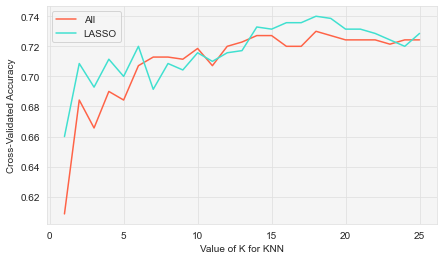

In [527]:
plt.rcParams['figure.figsize'] = (7, 4)

k_range = list(range(1, 26))
k_scores_all = []
k_scores_lasso = []
k_scores_chosen = []
k_scores_inter = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # all features
    scores_all = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores_all.append(scores_all.mean())

    # lasso subset
    scores_lasso = cross_val_score(knn, X_train_Lasso_KNN, y_train_Lasso_KNN, cv=10, scoring='accuracy')
    k_scores_lasso.append(scores_lasso.mean())

plt.plot(k_range, k_scores_all, label = "All")
plt.plot(k_range, k_scores_lasso, label = "LASSO")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.show()

What can be observed based on the above plot is that the accuracy grows for larger k. LASSO subset reaches the highest accuracy for the lowest k between 15 and 20. All feature subset converges a bit slower. 

### 3. KNN results

Moving on to the results, similar to previous cases, the function first selected the optimal parameters for each model using grid search cross-validation. The grid search was conducted with the following parameters:

* number of neighbors: [5, 6, 7, 8, 9, 11, 14, 15, 16]
* weights: ['uniform', 'distance']
* metric: ['minkowski', 'euclidean', 'manhattan']

In [528]:
params = { 'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15,16],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

df_full_knn, conf_matrix_knn, roc_knn, roc_auc_knn = model_results(X_train, y_train, X_test, y_test, "KNN All Features", KNeighborsClassifier, params, proba=True)
df_full_knn_Lasso, conf_matrix_knn_Lasso, roc_knn_Lasso, roc_auc_knn_Lasso = model_results(X_train_Lasso_KNN, y_train_Lasso_KNN, X_test_Lasso_KNN, y_test_Lasso_KNN, "KNN Lasso Features", KNeighborsClassifier, params, proba=True)
df_full_knn_ada, conf_matrix_knn_ada, roc_knn_ada, roc_auc_knn_ada = model_results(X_train_ada, y_train_ada, X_test, y_test, "KNN All Features ADASYN", KNeighborsClassifier, params, proba=True)
df_full_knn_Lasso_ada, conf_matrix_knn_Lasso_ada, roc_knn_Lasso_ada, roc_auc_knn_Lasso_ada = model_results(X_train_Lasso_KNN_ada, y_train_Lasso_KNN_ada, X_test_Lasso_KNN, y_test_Lasso_KNN, "KNN Lasso Features ADASYN", KNeighborsClassifier, params, proba=True)

KNN_summary = pd.concat([df_full_knn, df_full_knn_Lasso, df_full_knn_ada, df_full_knn_Lasso_ada], axis = 0)
KNN_summary

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,KNN All Features,"{'metric': 'minkowski', 'n_neighbors': 14, 'weights': 'uniform'}",0.727143,0.201835,0.143979,0.710000,0.966507,0.120879,407
0,KNN Lasso Features,"{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}",0.747143,0.308943,0.239899,0.716667,0.937799,0.208791,373
0,KNN All Features ADASYN,"{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}",0.807810,0.515837,0.576923,0.643333,0.650718,0.626374,243
0,KNN Lasso Features ADASYN,"{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}",0.815379,0.533333,0.579710,0.673333,0.698565,0.615385,238


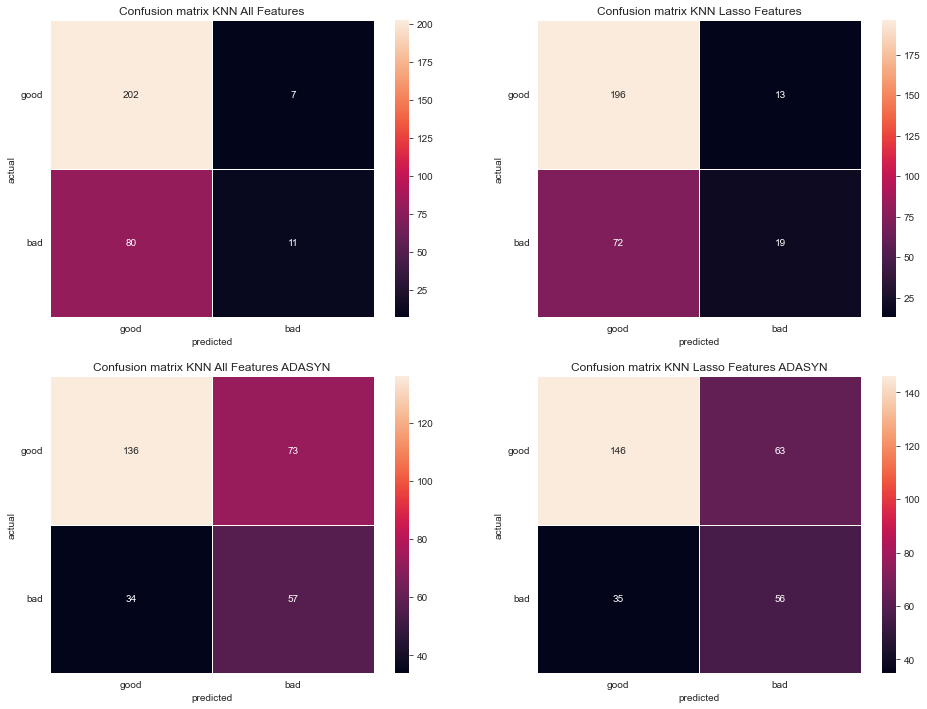

In [529]:
conf_matrix_plot_list([conf_matrix_knn,conf_matrix_knn_Lasso,conf_matrix_knn_ada,conf_matrix_knn_Lasso_ada],["KNN All Features", "KNN Lasso Features","KNN All Features ADASYN", "KNN Lasso Features ADASYN"])

### K-Nearest Neighbors (KNN) Results

**1. KNN with All Features:**

This setup displays a relatively high specificity, meaning it is more accurate in identifying 'good' (non-default) cases but has a high number of false negatives, where 'bad' (defaults) are misclassified as 'good'. 

**2. KNN with Lasso Features:**

Using Lasso-selected features results in a slight improvement in accuracy and F1, F2 scores compared to using all features. This model has a better balance between specificity and sensitivity, indicating it is somewhat better at identifying both 'good' and 'bad' cases. However, like the model with all features, it still shows a notable number of false negatives, though reduced. The cost decreases, suggesting fewer misclassifications of high-risk cases.

**3. KNN with All Features and ADASYN:**

Introducing ADASYN significantly increases the model's sensitivity, allowing it to detect more 'bad' cases. However, this comes at the cost of lower specificity, as more 'good' cases are misclassified as 'bad'. The F1 and F2 scores improve notably, indicating a better trade-off between precision and recall. The cost is also reduced, highlighting a more balanced classification approach, though the overall accuracy slightly decreases due to the increased number of false positives.

**4. KNN with Lasso Features and ADASYN:**

This model shows the best performance among the KNN setups, with the highest sensitivity, F1, and F2 scores, indicating a strong ability to detect 'bad' cases. The use of ADASYN with Lasso-selected features enhances the model's capability to correctly classify 'bad' cases while maintaining a moderate number of false positives. Specificity decreases compared to non-ADASYN models, but the cost is the lowest, suggesting that this approach provides the most balanced and cost-effective solution.

**Summary**

**1. Effect of ADASYN on Model Performance:**

* Incorporating ADASYN sampling led to a notable increase in sensitivity for both feature sets. This indicates that ADASYN helped the model better recognize and classify the minority class (bad credit cases), which is crucial in reducing the risk of misclassifying risky applicants as low-risk.

**2. Feature Selection and Accuracy:**

* The use of Lasso-selected features generally resulted in a slight improvement in accuracy compared to using all features.  This suggests that the Lasso feature selection helped in excluding irrelevant or less important features, thereby enhancing the model’s focus on more predictive variables.

**3. Cost Analysis:**

* The cost metric, which is crucial given the financial implications of misclassifications, was lowest for the KNN model using Lasso-selected features with ADASYN . This configuration not only minimized the financial loss from incorrect classifications but also provided a good balance between specificity and sensitivity, which is important in practical applications where the cost of false positives and false negatives varies significantly.


**4. F1 and F2 Scores:**

* The F1 and F2 scores, which provide a balance between precision and recall, were higher for models utilizing ADASYN, indicating a better overall classification performance in the context of imbalanced data. The highest F1 and F2 scores were observed in the KNN model with Lasso features and ADASYN, reinforcing the effectiveness of feature selection combined with class balancing techniques.

**5. Model Choice:**

* The KNN model with Lasso features and ADASYN, as explained in the points above.

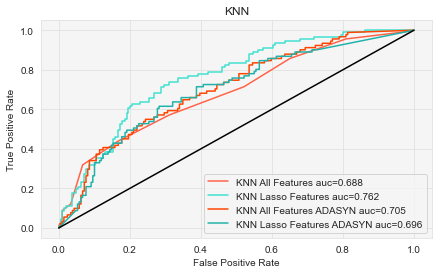

In [530]:
labels = ["KNN All Features", "KNN Lasso Features","KNN All Features ADASYN", "KNN Lasso Features ADASYN"]
rocs = [roc_knn, roc_knn_Lasso, roc_knn_ada, roc_knn_Lasso_ada]
aucs = [roc_auc_knn,roc_auc_knn_Lasso, roc_auc_knn_ada, roc_auc_knn_Lasso_ada]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN")
plt.legend(loc=4)
plt.show()

Using Lasso-selected features generally improved the AUC score. For models without ADASYN sampling, the AUC increased from 0.688 to 0.762. However, with ADASYN sampling, the AUC increased only slightly, from 0.685 to 0.723. Notably, the use of ADASYN sampling actually decreased the overall AUC. The best performing model, with the highest AUC score, was the KNN model using Lasso-selected features, achieving an AUC of 0.762.

## Decision Trees 

### 1. Calculating Feature Importance

In case of decision trees I have used a built in method 'feature_importances_'. The scores are calculated on the weighted Gini indices.

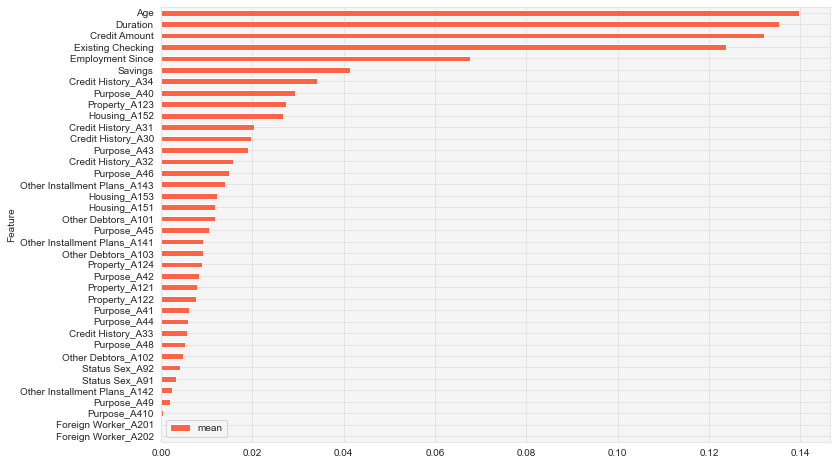

In [531]:
list_results = []
for i in range(10):
    model = DecisionTreeClassifier()
    model.fit(X_train,y_train)
    feat_importances_Decision_Trees = pd.DataFrame({'Importance': model.feature_importances_})
    list_results.append(feat_importances_Decision_Trees)

df_feat_importance = pd.concat(list_results, axis=1)
df_feat_importance['mean'] = df_feat_importance.mean(axis=1)
df_feat_importance = pd.concat([pd.DataFrame({'Feature': Predictors}), df_feat_importance], axis = 1)
df_feat_importance = df_feat_importance[['Feature', 'mean']]
feat_importances_Decision_Trees = df_feat_importance.sort_values(by="mean", ascending = True)
feat_importances_Decision_Trees
feat_importances_Decision_Trees.plot(x='Feature', y='mean', kind='barh', figsize=(12, 8))
plt.show()

 To analyze the impact of different features, I visually inspected the importance scores and selected a subset of the top 5 most important features, all of which had an index above 0.05. These top features were then compared with the complete set of features to assess their relative importance.

### 2. Choosing feature subsets based on Importance Plots

In [532]:
# top 5 features
print("Sum of mean importance for top 5 features: ",sum(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(5)['mean']))
DT_top5 = list(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(5)['Feature'])

Sum of mean importance for top 5 features:  0.598356736122911


In [533]:
# top 5 feature subset
X_top5_DT = df_comb[DT_top5].values
X_train_top5_DT, X_test_top5_DT, y_train_top5_DT, y_test_top5_DT = train_test_split(X_top5_DT , y, test_size=0.3, random_state=42)
X_train_top5_DT = PredictorScaler.fit_transform(X_train_top5_DT)
X_test_top5_DT = PredictorScaler.transform(X_test_top5_DT)

# with ADASYN
X_train_top5_DT_ada, y_train_top5_DT_ada = ada.fit_resample(X_train_top5_DT,y_train_top5_DT)


### 3. Decision Trees results



In [534]:
params = {'criterion' : ['gini', 'entropy'],
              'max_depth' : range(1,10),
              'min_samples_split' : range(2,10),
              'min_samples_leaf' : range(1,5)}

df_full_DT_top5, conf_matrix_DT_top5, roc_DT_top5, roc_auc_DT_top5 = model_results(X_train_top5_DT, y_train_top5_DT, X_test_top5_DT, y_test_top5_DT, "DT top5 Features", DecisionTreeClassifier, params, proba=True)
df_full_DT, conf_matrix_DT, roc_DT, roc_auc_DT = model_results(X_train, y_train, X_test, y_test, "DT All Features", DecisionTreeClassifier, params, proba=True)
df_full_DT_top5_ada, conf_matrix_DT_top5_ada, roc_DT_top5_ada, roc_auc_DT_top5_ada = model_results(X_train_top5_DT_ada, y_train_top5_DT_ada, X_test_top5_DT, y_test_top5_DT, "DT top5 Features ADASYN", DecisionTreeClassifier, params, proba=True)
df_full_DT_ada, conf_matrix_DT_ada, roc_DT_ada, roc_auc_DT_ada = model_results(X_train_ada, y_train_ada, X_test, y_test, "DT All Features ADASYN", DecisionTreeClassifier, params, proba=True)

DT_summary = pd.concat([df_full_DT, df_full_DT_top5, df_full_DT_top5_ada, df_full_DT_ada ], axis = 0)
DT_summary


,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,DT All Features,"{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}",0.738571,0.391608,0.336538,0.710000,0.885167,0.307692,339
0,DT top5 Features,"{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.732857,0.425806,0.385514,0.703333,0.851675,0.362637,321
0,DT top5 Features ADASYN,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 4}",0.700000,0.537037,0.593047,0.666667,0.679426,0.637363,232
0,DT All Features ADASYN,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2}",0.780617,0.535354,0.562633,0.693333,0.741627,0.582418,244


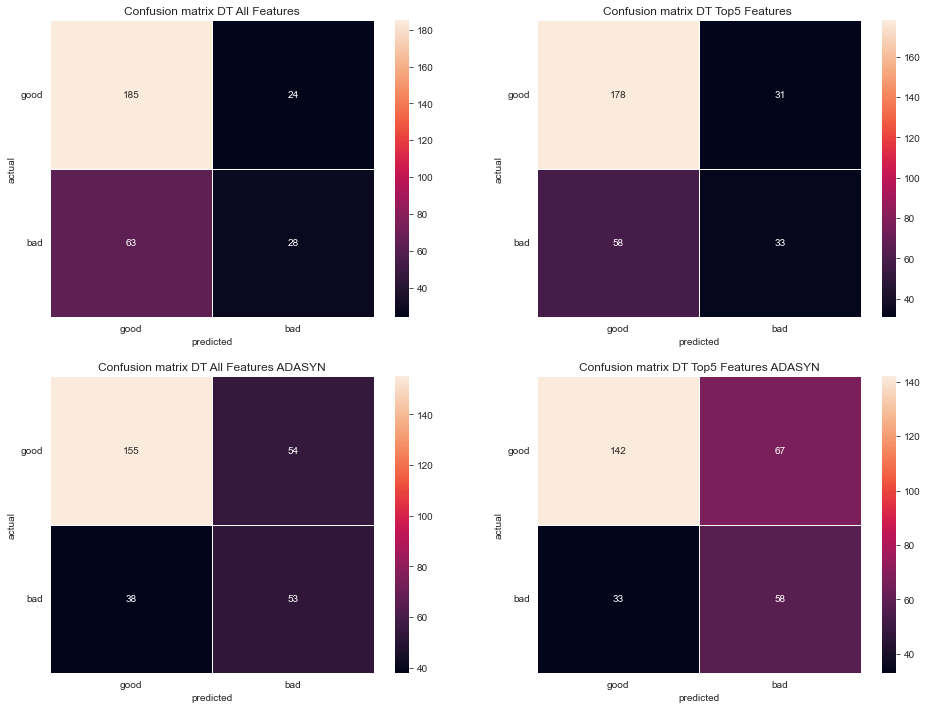

In [535]:
conf_matrix_plot_list([conf_matrix_DT,conf_matrix_DT_top5, conf_matrix_DT_ada, conf_matrix_DT_top5_ada],["DT All Features", "DT Top5 Features ", "DT All Features ADASYN", "DT Top5 Features ADASYN"])

**1. Decision Trees with All Features:**

This setup demonstrates a relatively high specificity, indicating strong performance in correctly identifying non-defaults. However, it has a lower sensitivity, meaning it misses a significant number of defaults (false negatives). The low F1 and F2 scores reflect a suboptimal balance between precision and recall, which can be critical in contexts where identifying all positive cases is essential.

**2. Decision Trees with Top 5 Features:**

Using only the top 5 features selected based on importance improves the model’s performance metrics slightly. There is an increase in both F1 and F2 scores compared to the model using all features, suggesting a better balance between precision and recall. This model shows a higher accuracy and sensitivity, indicating a better capacity for identifying defaults, although specificity remains high, similar to the all-features model.

**3. Decision Trees with Top 5 Features and ADASYN:**

The inclusion of ADASYN sampling with the top 5 features significantly enhances the model's sensitivity, indicating a better ability to detect defaults. This comes with an increased rate of false positives, as evidenced by a lower specificity. However, the F1 and F2 scores are notably improved, reflecting a more balanced approach between identifying true positives and avoiding false negatives. The cost is reduced, making this approach more efficient.

**4. Decision Trees with All Features and ADASYN:**

This configuration offers a balanced trade-off between sensitivity and specificity. It provides better sensitivity than the non-ADASYN models, meaning it correctly identifies more defaults. However, this model performs slightly worse compared to Top % Features and ADASYn model in terms of F1/ f2 scores, sensitivity and most importantly cost.

**Summary:**

**1. Impact of Feature Selection:**

The decision tree models using the top 5 features generally show improved performance metrics, including accuracy and F1/F2 scores, compared to models using all features. This suggests that feature selection can enhance the model’s ability to focus on the most relevant information, reducing overfitting and improving predictive accuracy.

**2. Effect of ADASYN Sampling:**

ADASYN sampling significantly improves sensitivity across the models, as shown by higher F1 and F2 scores. This indicates better identification of defaults, crucial for applications like credit risk assessment. However, this improvement in sensitivity usually comes at the cost of specificity, as the model becomes more prone to false positives.

**3. Cost Efficiency:**

Models utilizing ADASYN are generally more cost-efficient, primarily because they reduce the number of false negatives, which are often more costly in financial contexts. This reduction in cost makes these models more appealing despite the potential trade-off with specificity.

**4. Model Choice:**

* **Best Performing Model**: The decision tree model with top 5 features and ADASYN sampling is the most balanced, showing high sensitivity and improved F1/F2 scores with a reduced cost. This model is ideal for scenarios requiring a balance between identifying defaults and managing false positives.

* **For Balanced Performance:** The decision tree model with all features and ADASYN offers a good compromise, balancing accuracy, sensitivity, and cost. It is suitable for situations where both the identification of defaults and the minimization of false positives are important.

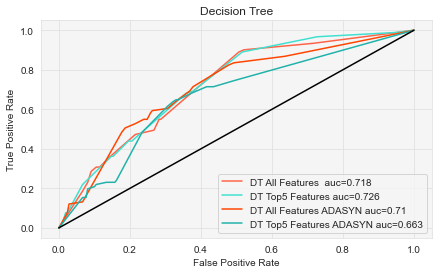

In [536]:
labels = ["DT All Features ",  "DT Top5 Features", "DT All Features ADASYN",  "DT Top5 Features ADASYN"]
rocs = [roc_DT, roc_DT_top5, roc_DT_ada, roc_DT_top5_ada]
aucs = [roc_auc_DT,roc_auc_DT_top5, roc_auc_DT_ada, roc_auc_DT_top5_ada]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree")
plt.legend(loc=4)
plt.show()

Generally, the top 5 feature subsets present higher AUC scores compared to the all-feature subset. In addition, ADASYN sampling slightly decreases the AUC.

## Results Summary

In order to summarise all of the proposed models i have prepared a couple of bar charts, which help to visually comapare all models using different statistics. Comapred metrics include:
* $F_1$ score, 
* Specificity & sensitivity,
* Accuracy,
* Cost.

In [537]:
df_results = pd.concat([LG_summary, KNN_summary, DT_summary ], axis = 0).sort_values(by= "cost").drop(columns=['parameters'])
df_results

,model_name,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,DT top5 Features ADASYN,0.700000,0.537037,0.593047,0.666667,0.679426,0.637363,232
0,Logistic Regression All Features ADASYN,0.691628,0.519824,0.590000,0.636667,0.631579,0.648352,237
0,Logistic Regression Top7 ADASYN,0.667463,0.508333,0.594542,0.606667,0.578947,0.670330,238
0,KNN Lasso Features ADASYN,0.815379,0.533333,0.579710,0.673333,0.698565,0.615385,238
0,KNN All Features ADASYN,0.807810,0.515837,0.576923,0.643333,0.650718,0.626374,243
0,DT All Features ADASYN,0.780617,0.535354,0.562633,0.693333,0.741627,0.582418,244
0,DT top5 Features,0.732857,0.425806,0.385514,0.703333,0.851675,0.362637,321
0,DT All Features,0.738571,0.391608,0.336538,0.710000,0.885167,0.307692,339
0,Logistic Regression All Features,0.735714,0.355556,0.294118,0.710000,0.904306,0.263736,355
0,KNN Lasso Features,0.747143,0.308943,0.239899,0.716667,0.937799,0.208791,373


<Axes: title={'center': 'F_1 Score Comparison'}, xlabel='F1 Score'>

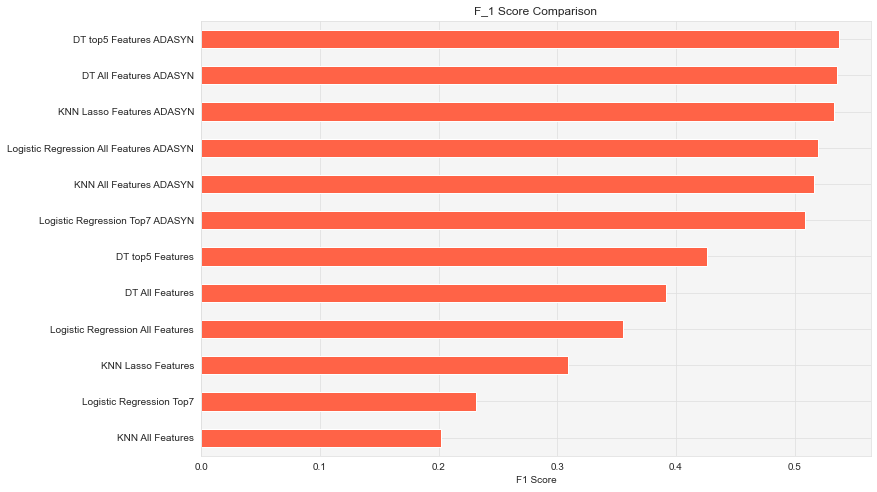

In [538]:
df_groups_f1 = df_results[['model_name', 'f1_test']].groupby(['model_name'])['f1_test'].sum().sort_values()
df_groups_f1.plot(kind='barh',xlabel='F1 Score',ylabel = "", figsize=(12, 8), title = "F_1 Score Comparison")

### $F_1$ Score Comaprison

* As mentioned earlier the use of ADASYN sampling leads to a significant improvement in the $F_1$ score regardless of classification model type. 

* Aside from Logistic Regression, another step of carefully performed feature selection helps to improve the metric score.  

Top 3 best models include:
* Decision Trees with Top 5 Features ADASYN,
* Decision Trees with All Features ADASYN, 
* KNN Lasso Features ADASYN. 


<Axes: title={'center': 'Specificity & Sensitivity Comparison'}>

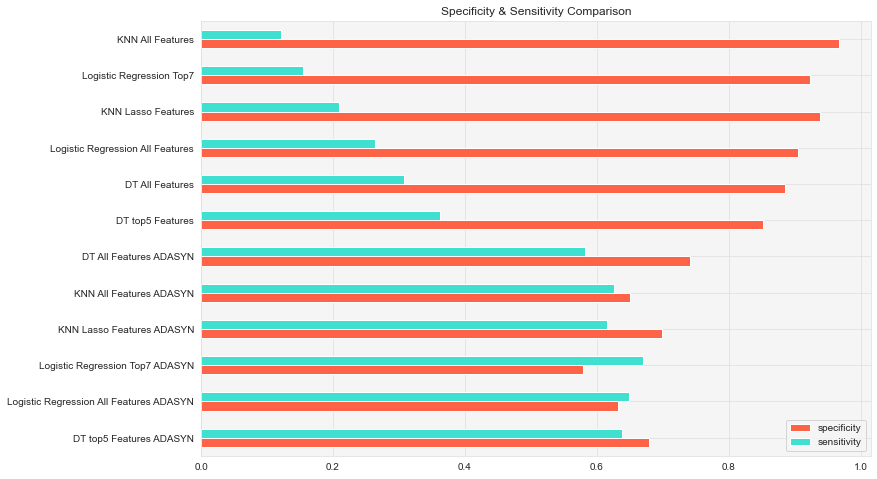

In [539]:
df_groups_s = df_results[['model_name', 'specificity', 'sensitivity']].groupby(['model_name']).sum().sort_values(by = "sensitivity", ascending = False)
df_groups_s
df_results.plot(x="model_name", y=["specificity", "sensitivity"], ylabel = "" ,kind="barh", figsize=(12, 8), title = "Specificity & Sensitivity Comparison")

### Sensitivity vs. Specificity Comparison.

Here the specificity vs. sensitivity trade-off is clearly visible. Since identifying defaulters is more valuabe than identifying non-defaulters, in this case improving sensitivity is considered a priority.  

Top 3 best models include:
* Decision Trees with Top 5 Features ADASYN,
* Logistic Regression with All Features ADASYN, 
* Logistic Regression Top 7 Features ADASYN.

For all of these Decision Trees with Top 5 Features ADASYN, Logistic Regression with All Features ADASYN both sensitivity & specificity remain above 0.6. Logistic Regression Top 7 Features ADASYN has the highest sensitivity overall.

<Axes: title={'center': 'Accuracy Comparison'}, xlabel='Accuracy'>

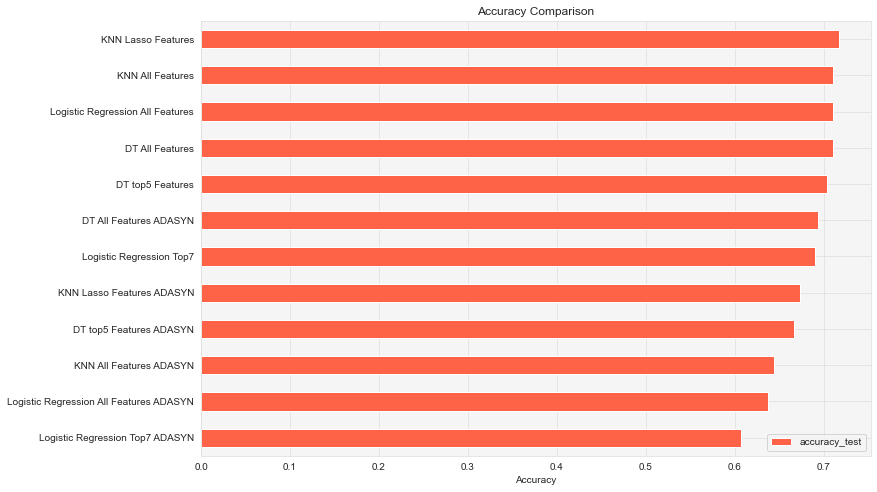

In [540]:
df_results.sort_values(by= "accuracy_test").plot(x="model_name", y=["accuracy_test"], kind="barh", xlabel = "Accuracy", ylabel = "", figsize=(12, 8), title = "Accuracy Comparison")

### Accuarcy Comaprison

Given the imbalanced data, accuracy is not the most reliable metric for model comparison, as it does not differentiate between false positives and false negatives. Nevertheless, the accuracy differences across models are relatively small, ranging from 0.6 to about 0.73. Interestingly, the highest accuracy scores come from models without ADASYN sampling or additional feature selection steps.

<Axes: title={'center': 'Cost Comparison'}>

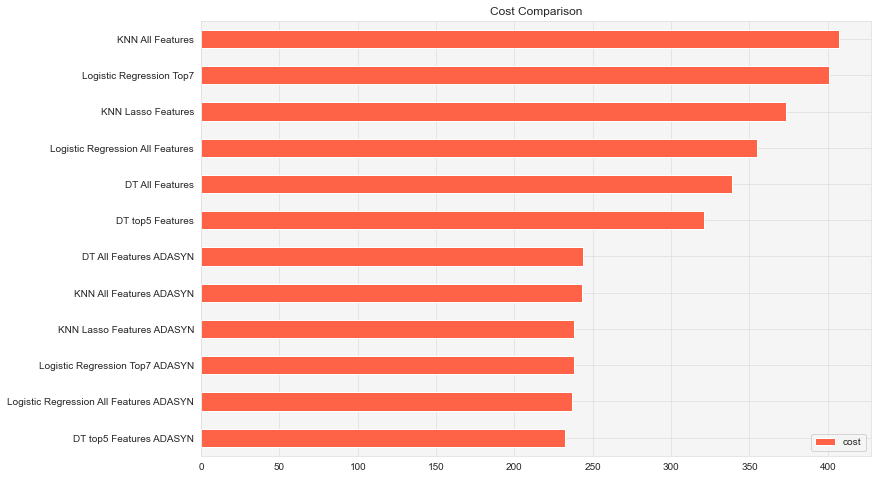

In [541]:
df_results.plot(x="model_name", y=["cost"], ylabel = "" ,kind="barh", figsize=(12, 8), title = "Cost Comparison")

### Cost Comparison

In this analysis, minimizing cost is the primary goal, making models with ADASYN sampling the most effective. The difference in cost between models using ADASYN is minimal, highlighting the consistency of this sampling method in reducing costs. The overall best performer is the Decision Tree model with the top 5 features, closely followed by Logistic Regression models. On the other hand, KNN models demonstrate the lowest performance in terms of cost, particularly those without ADASYN.

### Final Model Recomendation

Taking into account all of the discussed metrics, the best model for this scenario prioritizing sensitivity while balancing specificity, having the highest $F_1$ score and cost is **Decision Tree Model with Top 5 features and ADASYN sampling**. 